goal:

- use librosa on 1000 audio files and/or 50 class folders minimum
- store information in a dataframe (excluding actual file data for now)
  - folder name, file name, sampling rate, data length, file length, file size(?)

In [12]:
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchaudio
import copy
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from tqdm import tqdm
from IPython.display import Audio

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from imblearn.over_sampling import RandomOverSampler

from math import floor

torch.set_printoptions(sci_mode=False)

In [13]:
# experimental parameters for model training, for simple configuration in a single cell.
# very useful for reporting spreadsheet

on_sciama = False # for changing source directory

folder_key = {}

split_interval_secs = 2
split_length = 10000000000000 # absurd number for future use
sample_rate = 16000

variance_threshold = 0.2
mean_threshold = 5

total_folders = 10
min_rating = 5.0
max_files_per_folder = 0

sampling_technique = "median"

test_size = 0.2

epochs = 100
batch_size = 1024
dropout_rate = 0.5
learning_rate = 0.001
momentum = 0
experimental = False
experimental_counter_limit = 10
save_best_to_file = False

In [14]:
if on_sciama:
    base_path = "/mnt/lustre/peprmint/train_audio/"
else:
    base_path = "../../datasets/birdsongs-combined/train_audio/"

In [15]:
def reset_seed():
    torch.manual_seed(1368)
    random.seed(1368)
    np.random.seed(1368)

reset_seed()

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).total_memory)

print(device)
print(torch.cuda.get_device_name())

8546353152
cuda
NVIDIA GeForce RTX 5060


In [27]:
# base_dir: directory of all the audio file folders
# split_interval_secs: the length of each sound clip when split up in a file.
#   - final dataframe will not contain any sound clips over/under this length
# sample_rate: sample rate of sound clips in hz
# total_folders: total folders to iterate through the files, given range of files per folder
# min_files_per_folder: minimum files to exist in the folder
# max_files_per_folder: maximum files to use inside the folder
def get_random_folders_filtered(base_dir: str, split_interval_secs: float, sample_rate: int = 32000, total_folders: int = 50, max_files_per_folder: int = -1, min_rating: float = 4.0):
    global split_length, folder_key

    # get the list of valid folders and files to analyse
    folder_key = {}

    folders = []
    valid_folders = set()
    valid_files = set([l.replace("\n", "") for l in open(f"rating_thresholds_at_least_10_classes/min_rating_{int(min_rating * 2)}.txt").readlines()])
    for f in valid_files: valid_folders.add(f.split("/")[0])
    for folder in [line.replace("\n", "") for line in open("folder_order.txt").readlines()]:
        if folder in valid_folders:
            folders.append(folder)

    folder_count = 0

    # if there are less folders than those specified, view all folders instead of given amount
    total_folders = min(len(folders), total_folders)

    rows = []
    
    for folder in folders:
        
        folder_path = base_dir + folder + "/"
        valid_folder_files = []
        # only iterate through the valid audio files
        for file in os.listdir(folder_path):
            if folder + "/" + file in valid_files:
                valid_folder_files.append(folder_path + file)
        random.shuffle(valid_folder_files)

        if max_files_per_folder > 0:
            valid_folder_files = valid_folder_files[:min(max_files_per_folder, len(valid_folder_files))]

        # iterate through each file in the folder
        for file_path in (progress_bar := tqdm(valid_folder_files)):
            # load file data and resample to sample_rate if necessary
            file_data, file_sample_rate_hz = torchaudio.load(uri=file_path, channels_first=True)
            if file_sample_rate_hz != sample_rate:
                file_data = torchaudio.functional.resample(file_data, orig_freq=file_sample_rate_hz, new_freq=sample_rate)

            # convert all audio into mono (1 channel) if audio is stereo (2 channels)
            if file_data.shape[0] == 2:
                file_data = file_data.mean(dim=0)
            else:
                file_data = file_data.flatten()

            # get total number of X second splits
            total_splits = floor(len(file_data) / int(sample_rate * split_interval_secs))
            
            # convert file data into mel-spectrogram fourier transform for feeding into CNN
            n_fft = 1024



            mel_spec_transform = torchaudio.transforms.MelSpectrogram(sample_rate = sample_rate, power=2, n_fft=n_fft)
            
            # OLD MEL-SPECTROGRAM TRANSFORMATION
            # amp_to_db_transform = torchaudio.transforms.AmplitudeToDB(stype="amplitude", top_db=80)
            # mel_spec_data_db = amp_to_db_transform(mel_spec_transform(file_data)).numpy()
            
            # NEW MEL-SPECTROGRAM TRANSFORMATION
            mel_spec_data_db = torchaudio.functional.amplitude_to_DB(mel_spec_transform(file_data), multiplier=20., amin=0, db_multiplier=1, top_db=80).numpy()
            mel_spec_data_db = mel_spec_data_db - mel_spec_data_db.min()
            

            
            # if file is at least X seconds.
            if total_splits >= 1:
                split_length = min(mel_spec_data_db.shape[1] // total_splits, split_length)
                mel_spec_splits = np.arange(0, mel_spec_data_db.shape[1], split_length)
                for i in range(len(mel_spec_splits) - 1):
                    start = mel_spec_splits[i]
                    end = mel_spec_splits[i + 1]

                    mel_spec_split = mel_spec_data_db[:, start:end]

                    row = {}
                    row["folder"] = folder
                    row["file"] = file_path.split("/")[-1]
                    row["mel_spec"] = mel_spec_split
                    row["mel_spec_shape"] = mel_spec_split.shape

                    # determine and filter for "silence":
                    var = np.var(mel_spec_split)
                    mean = np.mean(mel_spec_split)

                    #if var > variance_threshold:
                    print(f"{file_path}, {mean=}, {var=}")
                    # automatically keep anything ABOVE mean db level
                    if mean > mean_threshold:
                        rows.append(row)
                    else:
                        # if mean is LOW, only include those with variance ABOVE threshold
                        if var > variance_threshold:
                            rows.append(row)
                        else:
                            plt.imshow(mel_spec_split)
                            plt.colorbar(format='%+2.0f dB')
                            plt.show()

                folder_key[folder_count] = folder
            
            progress_bar.set_description(f"Folder {folder_count + 1}/{total_folders} - {folder}")
        
        # end loop if total_folders has been reached
        folder_count += 1
        if folder_count >= total_folders: break

    # trim the ends of some mel spectrograms because of stupid floating point nonsense
    for i, row in enumerate(rows):
        if row["mel_spec_shape"][1] != split_length:
            row["mel_spec"] = row["mel_spec"][:, :split_length]
            row["mel_spec_shape"] = row["mel_spec"].shape

    return pd.DataFrame(rows)

Folder 1/10 - dowwoo:   0%|          | 0/27 [00:00<?, ?it/s]

../../datasets/birdsongs-combined/train_audio/dowwoo/XC332244.mp3, mean=np.float32(8.207882), var=np.float32(120.24356)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC332244.mp3, mean=np.float32(10.131462), var=np.float32(137.74022)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC466635.mp3, mean=np.float32(16.826368), var=np.float32(330.93277)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC476564.ogg, mean=np.float32(5.8259826), var=np.float32(61.90629)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC476564.ogg, mean=np.float32(6.6461005), var=np.float32(77.04689)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC476564.ogg, mean=np.float32(6.2970138), var=np.float32(61.830345)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC210867.ogg, mean=np.float32(0.002156655), var=np.float32(0.013289915)


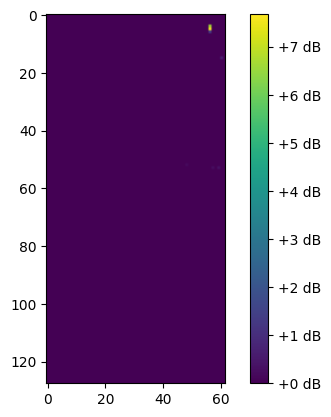

../../datasets/birdsongs-combined/train_audio/dowwoo/XC210867.ogg, mean=np.float32(6.2189903), var=np.float32(144.89764)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC210867.ogg, mean=np.float32(0.063866265), var=np.float32(0.32435772)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC210867.ogg, mean=np.float32(0.05178705), var=np.float32(0.25173658)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC210867.ogg, mean=np.float32(0.037160512), var=np.float32(0.1393455)


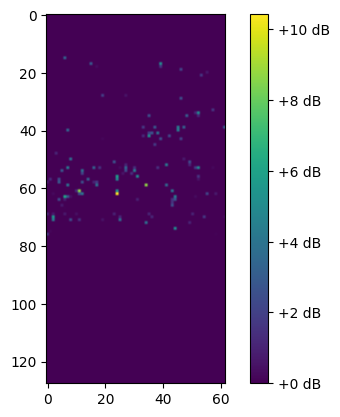

Folder 1/10 - dowwoo:  15%|█▍        | 4/27 [00:00<00:01, 14.54it/s]

../../datasets/birdsongs-combined/train_audio/dowwoo/XC210867.ogg, mean=np.float32(0.106686175), var=np.float32(1.1111964)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC210867.ogg, mean=np.float32(0.09520983), var=np.float32(0.70356196)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC210867.ogg, mean=np.float32(0.06346096), var=np.float32(0.32925528)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC210867.ogg, mean=np.float32(0.07213971), var=np.float32(0.74536204)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC210867.ogg, mean=np.float32(0.118715964), var=np.float32(2.826473)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC210867.ogg, mean=np.float32(5.643346), var=np.float32(139.90678)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC210867.ogg, mean=np.float32(0.056839954), var=np.float32(0.22851829)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC210867.ogg, mean=np.float32(0.07109282), var=np.float32(0.3307369)
../../datasets/birds

Folder 1/10 - dowwoo:  22%|██▏       | 6/27 [00:00<00:01, 13.88it/s]

../../datasets/birdsongs-combined/train_audio/dowwoo/XC567618.ogg, mean=np.float32(1.2340568), var=np.float32(26.881008)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC567618.ogg, mean=np.float32(1.2474388), var=np.float32(25.217655)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC567618.ogg, mean=np.float32(1.1366636), var=np.float32(24.704725)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC567618.ogg, mean=np.float32(1.2144678), var=np.float32(26.06621)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC567618.ogg, mean=np.float32(1.1940312), var=np.float32(28.926039)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC567618.ogg, mean=np.float32(1.1947343), var=np.float32(28.294876)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC567618.ogg, mean=np.float32(1.3318591), var=np.float32(28.12348)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC567618.ogg, mean=np.float32(1.1468929), var=np.float32(22.60035)
../../datasets/birdsongs-combined/t

Folder 1/10 - dowwoo:  30%|██▉       | 8/27 [00:00<00:01, 13.94it/s]

../../datasets/birdsongs-combined/train_audio/dowwoo/XC420821.ogg, mean=np.float32(2.7279482), var=np.float32(62.585842)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC420821.ogg, mean=np.float32(1.571336), var=np.float32(31.384325)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC420821.ogg, mean=np.float32(2.231538), var=np.float32(38.5992)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC420821.ogg, mean=np.float32(5.09628), var=np.float32(108.249985)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC420821.ogg, mean=np.float32(7.1233106), var=np.float32(152.41722)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC420821.ogg, mean=np.float32(6.4052114), var=np.float32(139.38281)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC420821.ogg, mean=np.float32(5.874249), var=np.float32(119.81044)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC420821.ogg, mean=np.float32(5.247281), var=np.float32(95.33356)
../../datasets/birdsongs-combined/train_

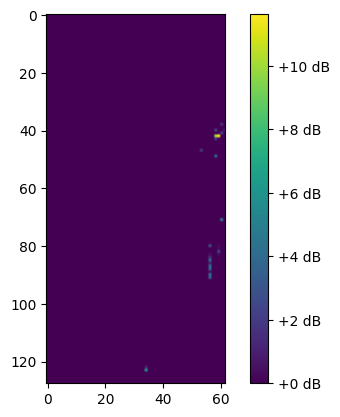

Folder 1/10 - dowwoo:  37%|███▋      | 10/27 [00:00<00:01, 11.83it/s]

../../datasets/birdsongs-combined/train_audio/dowwoo/XC210550.ogg, mean=np.float32(0.7285542), var=np.float32(18.738138)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC210550.ogg, mean=np.float32(0.111416645), var=np.float32(0.63851184)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC210550.ogg, mean=np.float32(0.124656536), var=np.float32(0.77176094)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC210550.ogg, mean=np.float32(0.8417739), var=np.float32(25.785198)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC210550.ogg, mean=np.float32(0.18693604), var=np.float32(1.249073)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC210550.ogg, mean=np.float32(0.54190814), var=np.float32(12.82602)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC210550.ogg, mean=np.float32(0.56803095), var=np.float32(4.5589256)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC210550.ogg, mean=np.float32(1.1558046), var=np.float32(13.325075)
../../datasets/birdsongs-

Folder 1/10 - dowwoo:  48%|████▊     | 13/27 [00:00<00:00, 15.53it/s]

../../datasets/birdsongs-combined/train_audio/dowwoo/XC193421.mp3, mean=np.float32(0.40673938), var=np.float32(15.250927)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC193421.mp3, mean=np.float32(2.7946823), var=np.float32(104.74362)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC144085.ogg, mean=np.float32(11.423863), var=np.float32(84.515915)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC144085.ogg, mean=np.float32(11.048438), var=np.float32(86.55028)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC144085.ogg, mean=np.float32(10.608306), var=np.float32(75.391525)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC144085.ogg, mean=np.float32(11.053986), var=np.float32(85.545944)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC144085.ogg, mean=np.float32(10.466045), var=np.float32(77.393135)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC144085.ogg, mean=np.float32(10.983386), var=np.float32(87.9475)
../../datasets/birdsongs-combined/

Folder 1/10 - dowwoo:  59%|█████▉    | 16/27 [00:01<00:00, 16.70it/s]

../../datasets/birdsongs-combined/train_audio/dowwoo/XC302575.ogg, mean=np.float32(5.7258406), var=np.float32(87.07647)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC302575.ogg, mean=np.float32(7.6536283), var=np.float32(115.86966)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC302575.ogg, mean=np.float32(4.596152), var=np.float32(54.022083)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC302575.ogg, mean=np.float32(8.628306), var=np.float32(156.97385)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC302575.ogg, mean=np.float32(4.48014), var=np.float32(45.4961)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC302575.ogg, mean=np.float32(9.360413), var=np.float32(114.48728)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC302575.ogg, mean=np.float32(16.666792), var=np.float32(247.41135)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC302575.ogg, mean=np.float32(18.759443), var=np.float32(178.03302)
../../datasets/birdsongs-combined/train_

Folder 1/10 - dowwoo:  67%|██████▋   | 18/27 [00:01<00:00, 17.14it/s]

../../datasets/birdsongs-combined/train_audio/dowwoo/XC416732.ogg, mean=np.float32(4.3385305), var=np.float32(114.59031)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC416732.ogg, mean=np.float32(4.4785414), var=np.float32(112.31453)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC416732.ogg, mean=np.float32(3.786239), var=np.float32(86.92013)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC416732.ogg, mean=np.float32(3.5387235), var=np.float32(75.263405)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC416732.ogg, mean=np.float32(3.579676), var=np.float32(78.16781)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC416732.ogg, mean=np.float32(4.264195), var=np.float32(87.930954)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC416732.ogg, mean=np.float32(4.492301), var=np.float32(92.98497)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC416732.ogg, mean=np.float32(4.961038), var=np.float32(104.33827)
../../datasets/birdsongs-combined/train_

Folder 1/10 - dowwoo:  74%|███████▍  | 20/27 [00:01<00:00, 15.61it/s]

../../datasets/birdsongs-combined/train_audio/dowwoo/XC599324.ogg, mean=np.float32(0.07691568), var=np.float32(0.44701424)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC599324.ogg, mean=np.float32(3.7325358), var=np.float32(114.77894)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC599324.ogg, mean=np.float32(0.6131699), var=np.float32(18.235846)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC599324.ogg, mean=np.float32(1.2478684), var=np.float32(34.418064)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC599324.ogg, mean=np.float32(3.1413903), var=np.float32(95.37313)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC599324.ogg, mean=np.float32(2.1295795), var=np.float32(64.96516)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC599324.ogg, mean=np.float32(2.5876195), var=np.float32(77.5815)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC599324.ogg, mean=np.float32(0.08158951), var=np.float32(0.9892903)
../../datasets/birdsongs-combined

Folder 1/10 - dowwoo:  74%|███████▍  | 20/27 [00:01<00:00, 15.61it/s]

../../datasets/birdsongs-combined/train_audio/dowwoo/XC543745.ogg, mean=np.float32(6.6688576), var=np.float32(147.09709)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC543745.ogg, mean=np.float32(10.882518), var=np.float32(192.01843)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC543745.ogg, mean=np.float32(6.7906837), var=np.float32(157.79417)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC543745.ogg, mean=np.float32(6.2309093), var=np.float32(137.42455)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC543745.ogg, mean=np.float32(8.066597), var=np.float32(155.996)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC543745.ogg, mean=np.float32(15.222129), var=np.float32(262.79535)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC543745.ogg, mean=np.float32(8.632817), var=np.float32(150.15944)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC543745.ogg, mean=np.float32(9.544618), var=np.float32(150.33846)
../../datasets/birdsongs-combined/tra

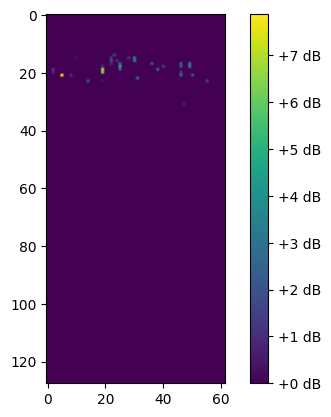

../../datasets/birdsongs-combined/train_audio/dowwoo/XC601009.ogg, mean=np.float32(0.010268825), var=np.float32(0.044227645)


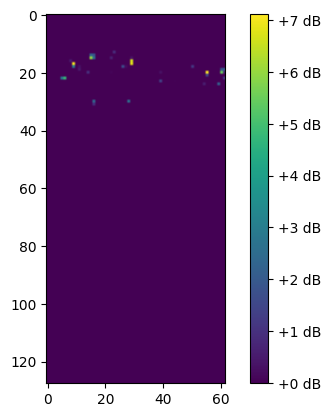

Folder 1/10 - dowwoo: 100%|██████████| 27/27 [00:01<00:00, 15.70it/s]


../../datasets/birdsongs-combined/train_audio/dowwoo/XC302574.mp3, mean=np.float32(16.447037), var=np.float32(332.90286)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC302574.mp3, mean=np.float32(14.321186), var=np.float32(273.2012)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC476563.ogg, mean=np.float32(2.75053), var=np.float32(40.20873)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC476563.ogg, mean=np.float32(2.104369), var=np.float32(23.524351)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC476563.ogg, mean=np.float32(4.3906903), var=np.float32(78.76593)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC612294.ogg, mean=np.float32(4.9263544), var=np.float32(135.16043)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC612294.ogg, mean=np.float32(3.0154626), var=np.float32(68.80654)
../../datasets/birdsongs-combined/train_audio/dowwoo/XC612294.ogg, mean=np.float32(7.8509827), var=np.float32(232.26015)
../../datasets/birdsongs-combined/train

  0%|          | 0/67 [00:00<?, ?it/s]

../../datasets/birdsongs-combined/train_audio/rerswa1/XC267777.ogg, mean=np.float32(0.26129064), var=np.float32(6.0505795)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC267777.ogg, mean=np.float32(1.777457), var=np.float32(52.78196)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC267777.ogg, mean=np.float32(2.220044), var=np.float32(61.40086)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC267777.ogg, mean=np.float32(1.3296124), var=np.float32(35.242367)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC267777.ogg, mean=np.float32(0.048813965), var=np.float32(0.7551987)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC267777.ogg, mean=np.float32(0.021859724), var=np.float32(0.24414648)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC267777.ogg, mean=np.float32(0.12932622), var=np.float32(1.9755398)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC267777.ogg, mean=np.float32(0.0019018463), var=np.float32(0.0067913346)


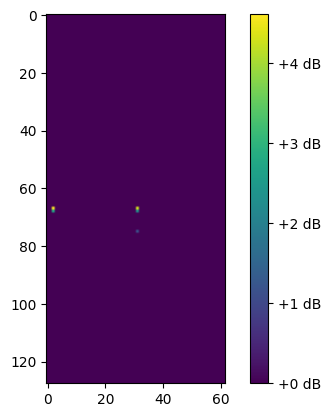

Folder 2/10 - rerswa1:   1%|▏         | 1/67 [00:00<00:08,  7.72it/s]

../../datasets/birdsongs-combined/train_audio/rerswa1/XC736964.ogg, mean=np.float32(11.780636), var=np.float32(101.32827)

Folder 2/10 - rerswa1:   1%|▏         | 1/67 [00:00<00:08,  7.72it/s]


../../datasets/birdsongs-combined/train_audio/rerswa1/XC736964.ogg, mean=np.float32(9.788591), var=np.float32(61.6689)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC736964.ogg, mean=np.float32(10.75251), var=np.float32(84.432236)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC736964.ogg, mean=np.float32(12.718842), var=np.float32(97.852005)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC736964.ogg, mean=np.float32(13.388038), var=np.float32(115.4228)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC423983.ogg, mean=np.float32(1.9748644), var=np.float32(48.84013)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC423983.ogg, mean=np.float32(1.8903335), var=np.float32(38.15861)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC423983.ogg, mean=np.float32(2.0923002), var=np.float32(22.320015)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC423983.ogg, mean=np.float32(1.4499402), var=np.float32(10.226697)
../../datasets/birdsongs-combi

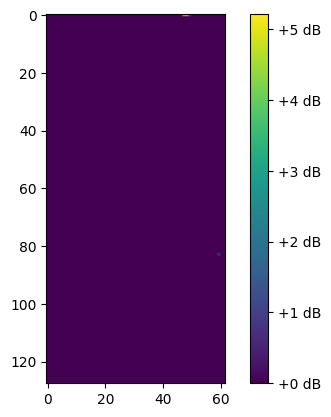

../../datasets/birdsongs-combined/train_audio/rerswa1/XC171583.ogg, mean=np.float32(0.11065799), var=np.float32(1.4242159)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC171583.ogg, mean=np.float32(1.5217924), var=np.float32(37.00748)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC171583.ogg, mean=np.float32(0.5722848), var=np.float32(18.734932)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC171583.ogg, mean=np.float32(0.09731231), var=np.float32(1.6119581)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC171583.ogg, mean=np.float32(2.9376576), var=np.float32(75.31868)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC171583.ogg, mean=np.float32(0.47890884), var=np.float32(12.601809)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC171583.ogg, mean=np.float32(0.46239468), var=np.float32(14.404785)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC171583.ogg, mean=np.float32(0.011603149), var=np.float32(0.07843178)


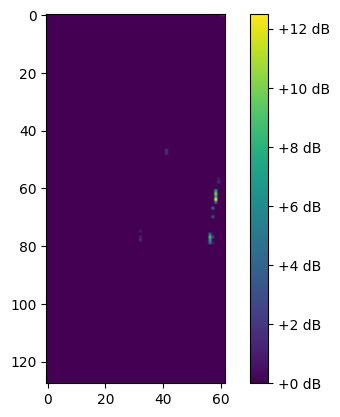

../../datasets/birdsongs-combined/train_audio/rerswa1/XC171583.ogg, mean=np.float32(0.2534531), var=np.float32(5.638706)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC171583.ogg, mean=np.float32(7.195194e-05), var=np.float32(4.108014e-05)


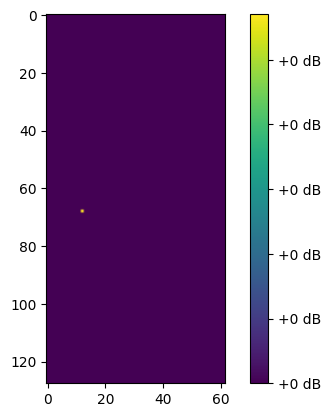

Folder 2/10 - rerswa1:   7%|▋         | 5/67 [00:00<00:06,  9.48it/s]

../../datasets/birdsongs-combined/train_audio/rerswa1/XC800475.ogg, mean=np.float32(1.9674547), var=np.float32(62.748493)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC800475.ogg, mean=np.float32(1.9200722), var=np.float32(53.828876)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC800475.ogg, mean=np.float32(1.6348609), var=np.float32(51.67471)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC800475.ogg, mean=np.float32(3.5978901), var=np.float32(104.45999)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC800475.ogg, mean=np.float32(2.4470701), var=np.float32(72.52835)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC800475.ogg, mean=np.float32(1.5208888), var=np.float32(40.086132)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC800475.ogg, mean=np.float32(0.8306933), var=np.float32(23.39717)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC800475.ogg, mean=np.float32(2.3756058), var=np.float32(65.098595)
../../datasets/birdsongs-co

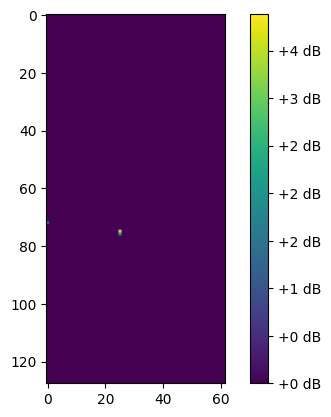

../../datasets/birdsongs-combined/train_audio/rerswa1/XC800475.ogg, mean=np.float32(0.0092635555), var=np.float32(0.09054497)


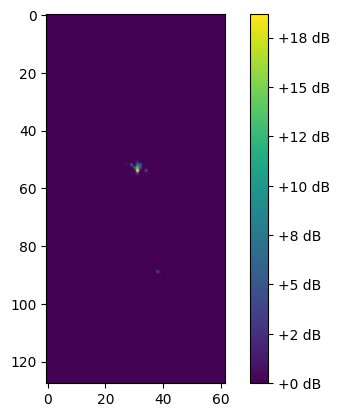

Folder 2/10 - rerswa1:   9%|▉         | 6/67 [00:00<00:09,  6.70it/s]

../../datasets/birdsongs-combined/train_audio/rerswa1/XC800475.ogg, mean=np.float32(0.09124233), var=np.float32(1.84359)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC148621.ogg, mean=np.float32(3.1071925), var=np.float32(79.615814)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC148621.ogg, mean=np.float32(0.9100388), var=np.float32(26.385023)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC148621.ogg, mean=np.float32(6.8609424), var=np.float32(178.55292)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC148621.ogg, mean=np.float32(2.6984146), var=np.float32(84.32418)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC148621.ogg, mean=np.float32(1.0612825), var=np.float32(34.571556)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC148621.ogg, mean=np.float32(4.8073783), var=np.float32(135.71957)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC672469.ogg, mean=np.float32(5.1768813), var=np.float32(61.979736)
../../datasets/birdsongs-c

Folder 2/10 - rerswa1:  15%|█▍        | 10/67 [00:01<00:04, 11.45it/s]

../../datasets/birdsongs-combined/train_audio/rerswa1/XC460972.ogg, mean=np.float32(0.19600327), var=np.float32(1.69917)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC460972.ogg, mean=np.float32(0.77175474), var=np.float32(14.034863)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC460972.ogg, mean=np.float32(0.57346714), var=np.float32(10.256215)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC460972.ogg, mean=np.float32(0.2075006), var=np.float32(1.9164901)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC460972.ogg, mean=np.float32(1.4352162), var=np.float32(28.204039)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC460972.ogg, mean=np.float32(0.31527993), var=np.float32(3.2158985)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC460972.ogg, mean=np.float32(0.20000516), var=np.float32(1.6865183)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC460972.ogg, mean=np.float32(0.1644532), var=np.float32(1.3652474)
../../datasets/birdso

Folder 2/10 - rerswa1:  24%|██▍       | 16/67 [00:01<00:02, 19.02it/s]

../../datasets/birdsongs-combined/train_audio/rerswa1/XC790247.ogg, mean=np.float32(5.026192), var=np.float32(45.945393)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC790247.ogg, mean=np.float32(4.4480247), var=np.float32(39.35965)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC790247.ogg, mean=np.float32(8.546319), var=np.float32(143.54564)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC423912.ogg, mean=np.float32(7.2551093), var=np.float32(140.6037)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC423912.ogg, mean=np.float32(6.162313), var=np.float32(125.395035)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC835051.ogg, mean=np.float32(0.11926864), var=np.float32(1.1507374)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC835051.ogg, mean=np.float32(0.20843156), var=np.float32(2.0964415)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC835051.ogg, mean=np.float32(2.5273707), var=np.float32(62.069492)
../../datasets/birdsongs-c

Folder 2/10 - rerswa1:  24%|██▍       | 16/67 [00:01<00:02, 19.02it/s]

../../datasets/birdsongs-combined/train_audio/rerswa1/XC585423.ogg, mean=np.float32(3.9300208), var=np.float32(64.026405)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC585423.ogg, mean=np.float32(6.690601), var=np.float32(127.820656)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC585423.ogg, mean=np.float32(9.075521), var=np.float32(143.16461)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC585423.ogg, mean=np.float32(10.271673), var=np.float32(152.6042)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC735053.ogg, mean=np.float32(4.6571636), var=np.float32(57.652683)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC735053.ogg, mean=np.float32(4.9162), var=np.float32(54.251617)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC735053.ogg, mean=np.float32(7.689981), var=np.float32(142.61432)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC735053.ogg, mean=np.float32(4.5436106), var=np.float32(49.405262)
../../datasets/birdsongs-combi

Folder 2/10 - rerswa1:  33%|███▎      | 22/67 [00:01<00:01, 23.82it/s]

../../datasets/birdsongs-combined/train_audio/rerswa1/XC827223.ogg, mean=np.float32(1.0474294), var=np.float32(20.327467)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC827223.ogg, mean=np.float32(1.7491962), var=np.float32(33.327103)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC827223.ogg, mean=np.float32(1.5204579), var=np.float32(35.763958)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC827223.ogg, mean=np.float32(1.4009367), var=np.float32(22.74387)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC827223.ogg, mean=np.float32(1.3732479), var=np.float32(23.660124)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC827223.ogg, mean=np.float32(0.52429444), var=np.float32(10.921334)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC827223.ogg, mean=np.float32(1.1375902), var=np.float32(17.498402)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC827223.ogg, mean=np.float32(1.2968752), var=np.float32(22.592337)
../../datasets/birdsongs

Folder 2/10 - rerswa1:  45%|████▍     | 30/67 [00:01<00:01, 33.22it/s]

../../datasets/birdsongs-combined/train_audio/rerswa1/XC835048.ogg, mean=np.float32(3.2600636), var=np.float32(21.049889)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC835048.ogg, mean=np.float32(5.4476624), var=np.float32(79.33025)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC835048.ogg, mean=np.float32(6.174123), var=np.float32(99.84358)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC835048.ogg, mean=np.float32(9.972867), var=np.float32(177.43605)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC835048.ogg, mean=np.float32(5.4823895), var=np.float32(63.88801)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC835048.ogg, mean=np.float32(7.1375), var=np.float32(108.24741)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC835048.ogg, mean=np.float32(6.5262957), var=np.float32(106.10998)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC835048.ogg, mean=np.float32(5.6431537), var=np.float32(76.99203)
../../datasets/birdsongs-combined

Folder 2/10 - rerswa1:  45%|████▍     | 30/67 [00:01<00:01, 33.22it/s]

../../datasets/birdsongs-combined/train_audio/rerswa1/XC463164.ogg, mean=np.float32(0.23531017), var=np.float32(3.9554653)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC463164.ogg, mean=np.float32(1.8269376), var=np.float32(38.7149)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC463164.ogg, mean=np.float32(3.9000115), var=np.float32(86.29294)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC463164.ogg, mean=np.float32(3.0727289), var=np.float32(56.348434)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC463164.ogg, mean=np.float32(1.1522714), var=np.float32(19.46622)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC463164.ogg, mean=np.float32(0.818187), var=np.float32(16.093874)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC463164.ogg, mean=np.float32(3.1127737), var=np.float32(72.10405)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC463164.ogg, mean=np.float32(1.5111743), var=np.float32(31.254745)
../../datasets/birdsongs-comb

Folder 2/10 - rerswa1:  51%|█████     | 34/67 [00:01<00:01, 27.01it/s]

../../datasets/birdsongs-combined/train_audio/rerswa1/XC193684.ogg, mean=np.float32(8.274158), var=np.float32(131.8339)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC193684.ogg, mean=np.float32(4.4630156), var=np.float32(60.143112)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC193684.ogg, mean=np.float32(3.832962), var=np.float32(50.94357)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC193684.ogg, mean=np.float32(4.502096), var=np.float32(69.04486)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC193684.ogg, mean=np.float32(9.079762), var=np.float32(160.51515)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC193684.ogg, mean=np.float32(7.969697), var=np.float32(141.99924)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC193684.ogg, mean=np.float32(9.132166), var=np.float32(153.1368)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC193684.ogg, mean=np.float32(4.3410497), var=np.float32(43.367607)
../../datasets/birdsongs-combined/

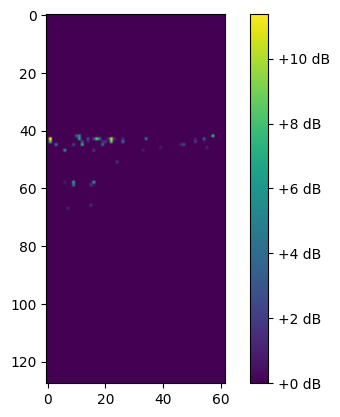

Folder 2/10 - rerswa1:  51%|█████     | 34/67 [00:01<00:01, 27.01it/s]

../../datasets/birdsongs-combined/train_audio/rerswa1/XC493838.ogg, mean=np.float32(0.18267457), var=np.float32(1.2907827)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC493838.ogg, mean=np.float32(0.9768597), var=np.float32(24.51164)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC493838.ogg, mean=np.float32(0.92207336), var=np.float32(16.918213)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC493838.ogg, mean=np.float32(0.44736162), var=np.float32(5.447614)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC383401.ogg, mean=np.float32(0.3766524), var=np.float32(13.504756)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC383401.ogg, mean=np.float32(2.3953123), var=np.float32(82.708885)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC383401.ogg, mean=np.float32(1.2464331), var=np.float32(27.692392)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC383401.ogg, mean=np.float32(1.7455325), var=np.float32(47.46691)
../../datasets/birdsongs

Folder 2/10 - rerswa1:  57%|█████▋    | 38/67 [00:01<00:01, 24.19it/s]

../../datasets/birdsongs-combined/train_audio/rerswa1/XC857585.ogg, mean=np.float32(0.16199054), var=np.float32(1.7568985)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC857585.ogg, mean=np.float32(4.2559557), var=np.float32(81.33482)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC857585.ogg, mean=np.float32(3.026693), var=np.float32(49.910995)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC857585.ogg, mean=np.float32(5.442841), var=np.float32(93.04216)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC857585.ogg, mean=np.float32(4.550139), var=np.float32(88.755745)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC857585.ogg, mean=np.float32(6.1457586), var=np.float32(119.206345)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC857585.ogg, mean=np.float32(6.589616), var=np.float32(124.11321)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC857585.ogg, mean=np.float32(5.0366044), var=np.float32(105.43871)
../../datasets/birdsongs-com

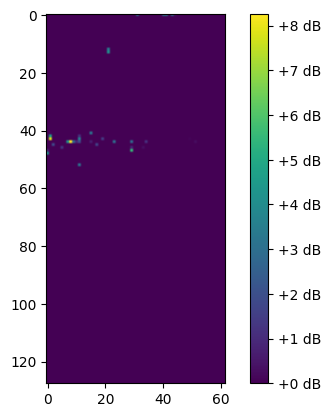

Folder 2/10 - rerswa1:  61%|██████    | 41/67 [00:02<00:01, 22.15it/s]

../../datasets/birdsongs-combined/train_audio/rerswa1/XC334161.ogg, mean=np.float32(0.17366116), var=np.float32(3.7282162)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC755868.ogg, mean=np.float32(3.452524), var=np.float32(120.21956)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC755868.ogg, mean=np.float32(1.8246816), var=np.float32(63.751015)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC755868.ogg, mean=np.float32(1.6927687), var=np.float32(56.580143)


Folder 2/10 - rerswa1:  61%|██████    | 41/67 [00:02<00:01, 22.15it/s]

../../datasets/birdsongs-combined/train_audio/rerswa1/XC463162.ogg, mean=np.float32(0.8637059), var=np.float32(18.48473)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC463162.ogg, mean=np.float32(4.2921224), var=np.float32(103.55759)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC463162.ogg, mean=np.float32(6.301545), var=np.float32(137.99707)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC463162.ogg, mean=np.float32(7.0544043), var=np.float32(166.37186)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC463162.ogg, mean=np.float32(7.293885), var=np.float32(169.81245)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC463162.ogg, mean=np.float32(4.870593), var=np.float32(114.49681)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC463162.ogg, mean=np.float32(5.228301), var=np.float32(120.9631)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC463162.ogg, mean=np.float32(7.8057065), var=np.float32(173.15344)
../../datasets/birdsongs-combi

Folder 2/10 - rerswa1:  66%|██████▌   | 44/67 [00:02<00:01, 20.32it/s]

../../datasets/birdsongs-combined/train_audio/rerswa1/XC857586.ogg, mean=np.float32(2.0754423), var=np.float32(68.05104)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC857586.ogg, mean=np.float32(1.4488611), var=np.float32(45.18381)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC857586.ogg, mean=np.float32(0.8741267), var=np.float32(23.855938)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC857586.ogg, mean=np.float32(2.415131), var=np.float32(69.73871)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC857586.ogg, mean=np.float32(2.2905288), var=np.float32(60.21904)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC837450.ogg, mean=np.float32(4.9949536), var=np.float32(76.01327)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC837450.ogg, mean=np.float32(4.6136546), var=np.float32(63.39983)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC837450.ogg, mean=np.float32(4.383432), var=np.float32(56.524754)
../../datasets/birdsongs-combine

Folder 2/10 - rerswa1:  70%|███████   | 47/67 [00:02<00:00, 20.52it/s]

../../datasets/birdsongs-combined/train_audio/rerswa1/XC423974.ogg, mean=np.float32(15.748429), var=np.float32(236.89204)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.2177039), var=np.float32(4.6524415)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.8089319), var=np.float32(26.080456)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.5759758), var=np.float32(27.06295)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.040517624), var=np.float32(0.8493813)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.49070123), var=np.float32(9.501478)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.0), var=np.float32(0.0)


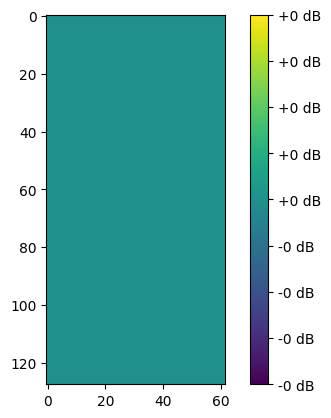

../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.32399836), var=np.float32(13.10651)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.6574688), var=np.float32(21.20343)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.0), var=np.float32(0.0)


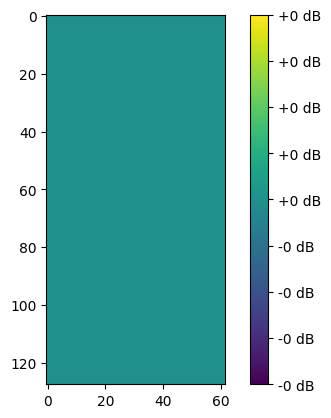

../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.022524172), var=np.float32(0.272155)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.0), var=np.float32(0.0)


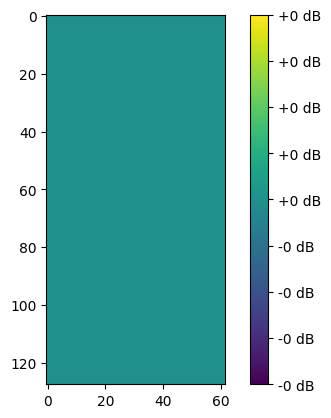

../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.06080853), var=np.float32(0.6002643)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.050793555), var=np.float32(0.8409282)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.7461363), var=np.float32(28.054207)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.0), var=np.float32(0.0)


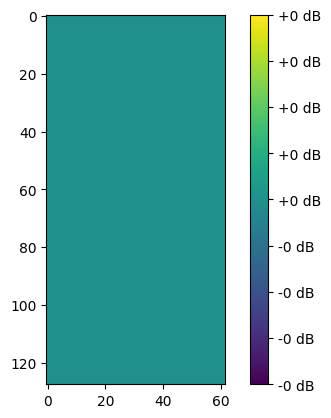

../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.03248123), var=np.float32(0.32921004)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.0881219), var=np.float32(1.0342983)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.019877173), var=np.float32(0.26042804)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.0), var=np.float32(0.0)


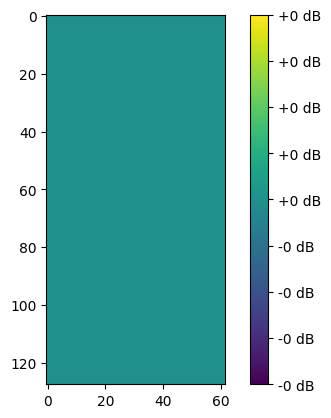

../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.0), var=np.float32(0.0)


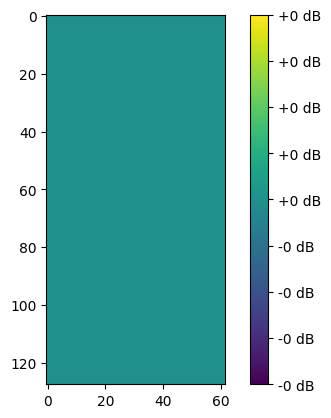

../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.0), var=np.float32(0.0)


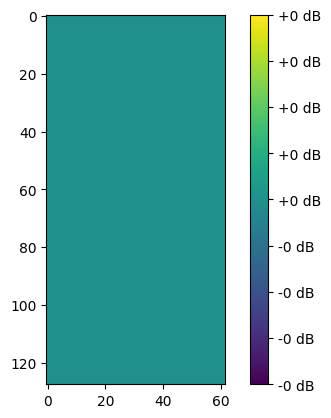

../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.0), var=np.float32(0.0)


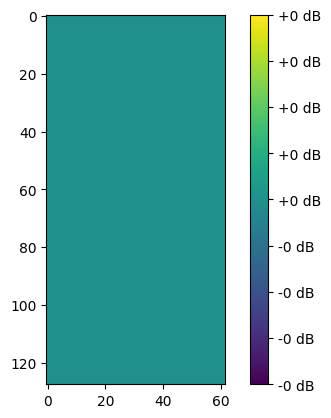

../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.0), var=np.float32(0.0)


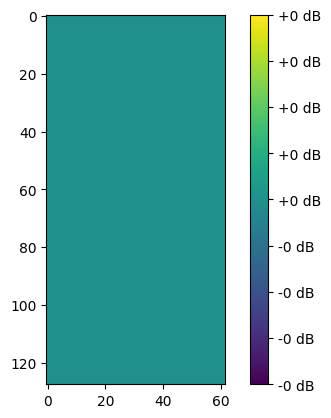

../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.0), var=np.float32(0.0)


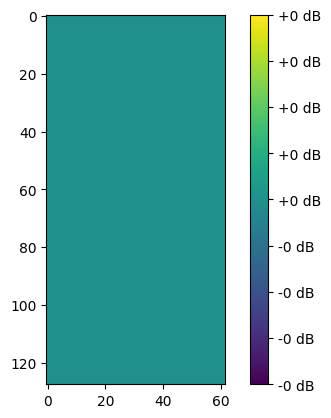

../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.0), var=np.float32(0.0)


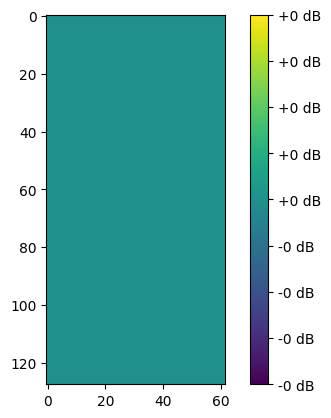

../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.0), var=np.float32(0.0)


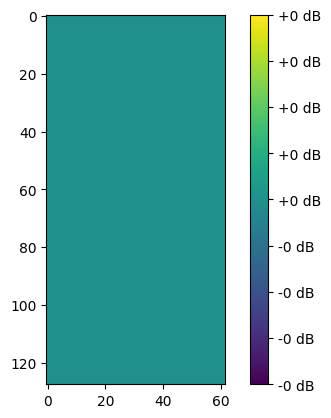

../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.22086021), var=np.float32(4.081823)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.982488), var=np.float32(23.539148)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(1.5450454), var=np.float32(38.986687)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.066066585), var=np.float32(2.1407375)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.0), var=np.float32(0.0)


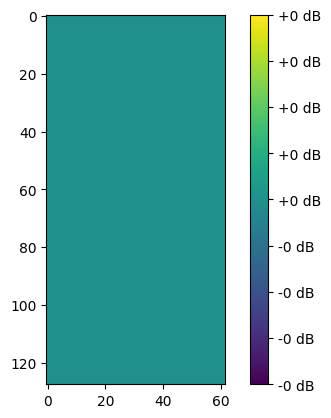

../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.0), var=np.float32(0.0)


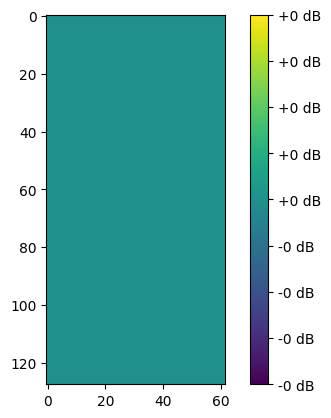

../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.0), var=np.float32(0.0)


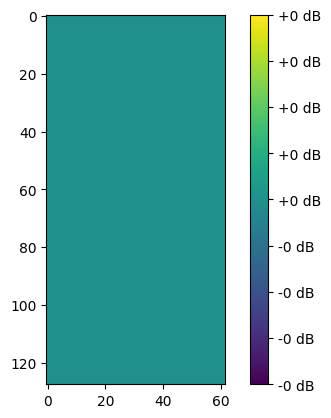

../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.0), var=np.float32(0.0)


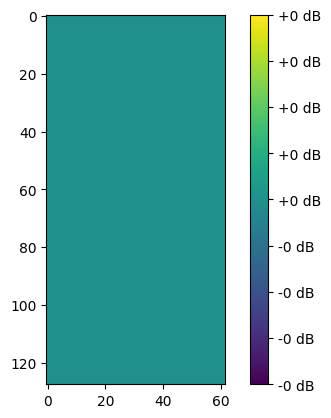

../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.0), var=np.float32(0.0)


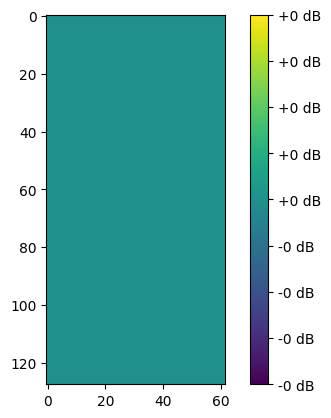

../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.0), var=np.float32(0.0)


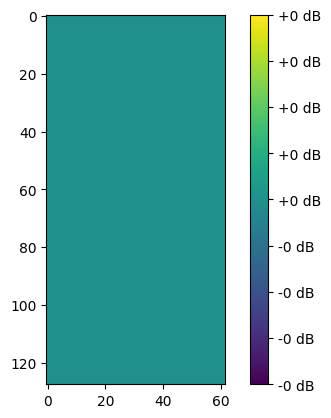

../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.0), var=np.float32(0.0)


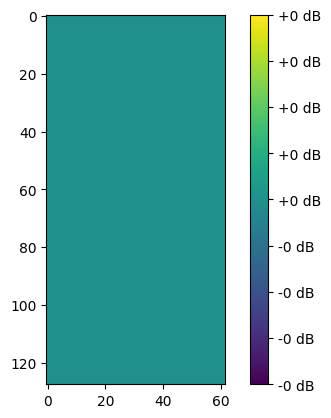

../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.0), var=np.float32(0.0)


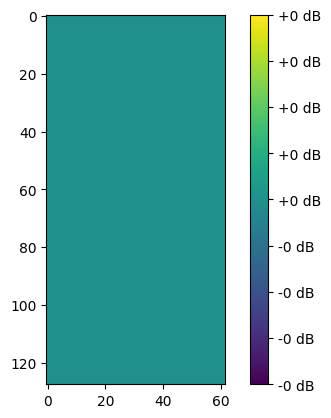

../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.0), var=np.float32(0.0)


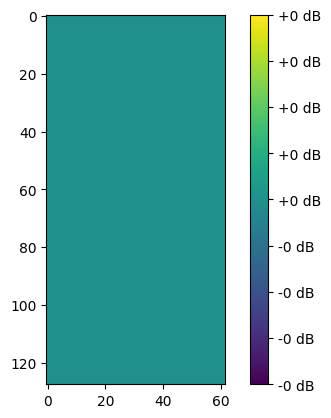

../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.0), var=np.float32(0.0)


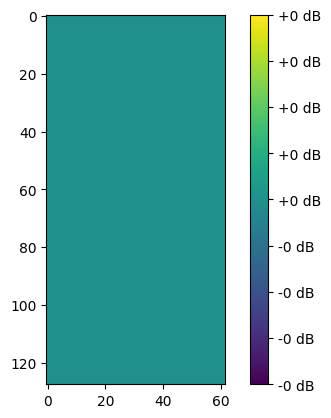

../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.0), var=np.float32(0.0)


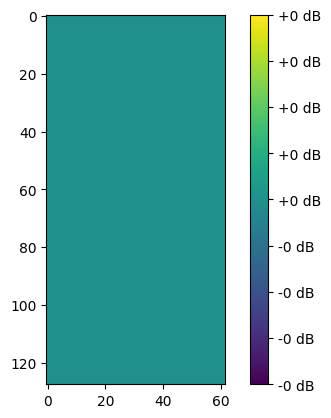

../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(4.9569673e-05), var=np.float32(1.9497505e-05)


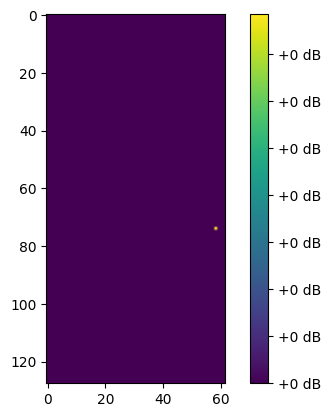

../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.0), var=np.float32(0.0)


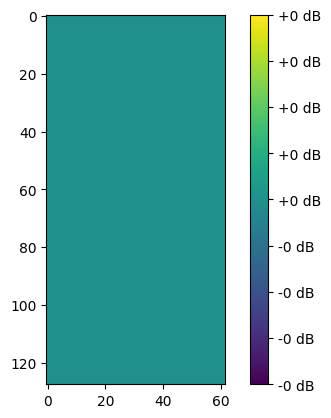

../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.0), var=np.float32(0.0)


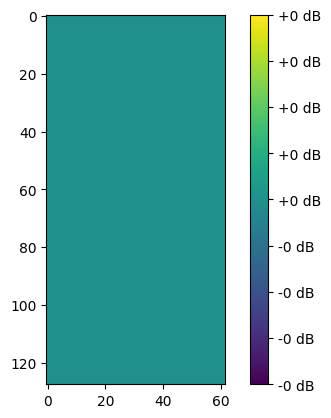

../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.0), var=np.float32(0.0)


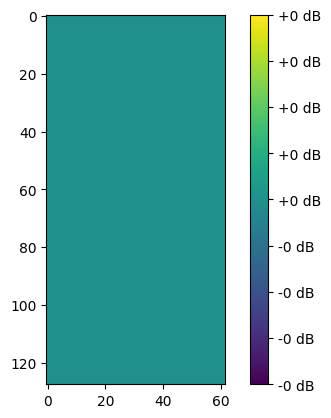

../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.0), var=np.float32(0.0)


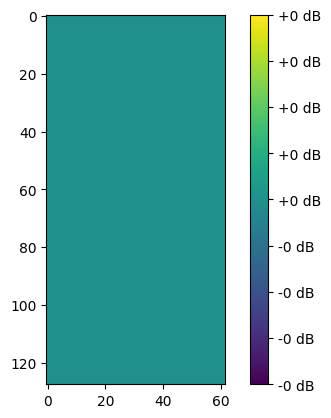

../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.21574327), var=np.float32(8.105082)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.35227478), var=np.float32(13.947784)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.037385896), var=np.float32(0.3084449)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.0), var=np.float32(0.0)


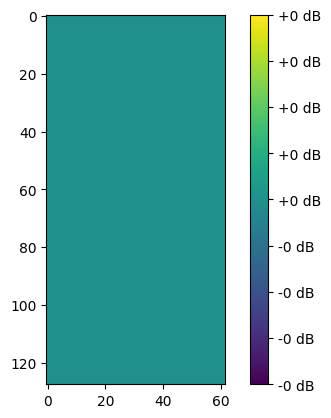

../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.05345254), var=np.float32(1.3956468)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.0), var=np.float32(0.0)


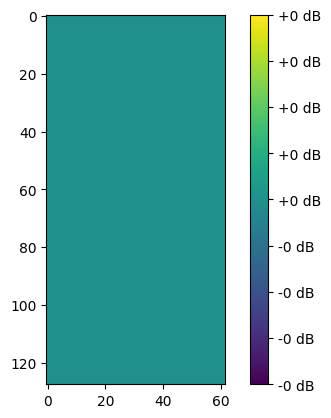

../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.0), var=np.float32(0.0)


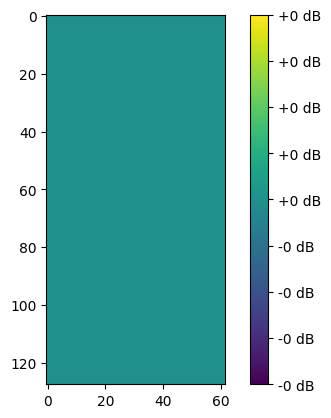

Folder 2/10 - rerswa1:  70%|███████   | 47/67 [00:05<00:00, 20.52it/s]

../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.060840454), var=np.float32(1.1156013)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.58855695), var=np.float32(16.789488)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.32444268), var=np.float32(6.3828588)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC171582.ogg, mean=np.float32(0.037994146), var=np.float32(0.3109)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC800474.ogg, mean=np.float32(2.922858), var=np.float32(91.82064)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC800474.ogg, mean=np.float32(0.009864657), var=np.float32(0.03148697)


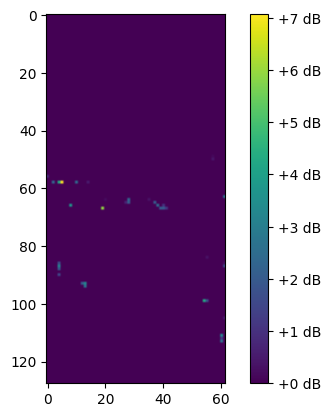

Folder 2/10 - rerswa1:  75%|███████▍  | 50/67 [00:05<00:06,  2.83it/s]

../../datasets/birdsongs-combined/train_audio/rerswa1/XC800474.ogg, mean=np.float32(1.7160476), var=np.float32(44.91421)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC800474.ogg, mean=np.float32(0.26243812), var=np.float32(3.030603)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC800474.ogg, mean=np.float32(0.13383757), var=np.float32(0.9886573)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC800474.ogg, mean=np.float32(2.3782246), var=np.float32(61.906754)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC800474.ogg, mean=np.float32(0.14404947), var=np.float32(1.5473337)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC800474.ogg, mean=np.float32(0.60809094), var=np.float32(12.085142)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC800474.ogg, mean=np.float32(0.13183549), var=np.float32(1.8754363)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC800474.ogg, mean=np.float32(0.10571381), var=np.float32(1.3129284)
../../datasets/birds

Folder 2/10 - rerswa1:  75%|███████▍  | 50/67 [00:06<00:06,  2.83it/s]

../../datasets/birdsongs-combined/train_audio/rerswa1/XC489638.ogg, mean=np.float32(10.51), var=np.float32(138.01314)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC489638.ogg, mean=np.float32(8.006922), var=np.float32(100.48776)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC489638.ogg, mean=np.float32(8.461546), var=np.float32(81.38004)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC489638.ogg, mean=np.float32(8.654003), var=np.float32(102.66433)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC489638.ogg, mean=np.float32(8.707068), var=np.float32(95.96371)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC794724.ogg, mean=np.float32(1.9030461), var=np.float32(45.980682)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC794724.ogg, mean=np.float32(0.6430612), var=np.float32(7.13627)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC794724.ogg, mean=np.float32(3.361565), var=np.float32(87.1129)
../../datasets/birdsongs-combined/train

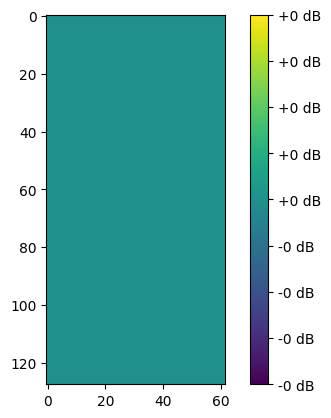

../../datasets/birdsongs-combined/train_audio/rerswa1/XC767569.ogg, mean=np.float32(2.191179), var=np.float32(81.18468)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC767569.ogg, mean=np.float32(0.0), var=np.float32(0.0)


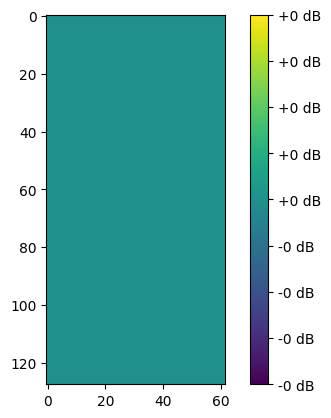

../../datasets/birdsongs-combined/train_audio/rerswa1/XC767569.ogg, mean=np.float32(0.4338162), var=np.float32(8.163236)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC767569.ogg, mean=np.float32(0.000345108), var=np.float32(0.00056147674)


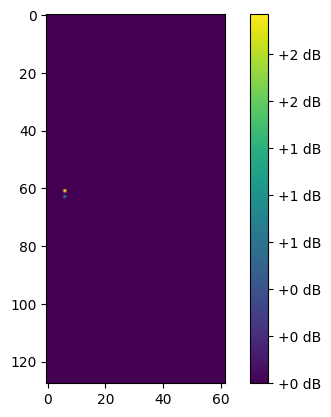

../../datasets/birdsongs-combined/train_audio/rerswa1/XC767569.ogg, mean=np.float32(2.1920826), var=np.float32(74.68328)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC767569.ogg, mean=np.float32(0.14176854), var=np.float32(2.2583873)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC767569.ogg, mean=np.float32(0.34785354), var=np.float32(5.7439814)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC767569.ogg, mean=np.float32(2.362019), var=np.float32(82.039055)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC767569.ogg, mean=np.float32(0.0), var=np.float32(0.0)


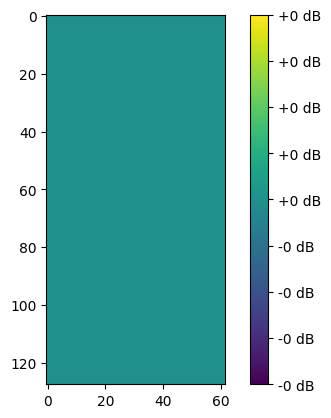

Folder 2/10 - rerswa1:  84%|████████▎ | 56/67 [00:06<00:02,  4.21it/s]

../../datasets/birdsongs-combined/train_audio/rerswa1/XC381917.ogg, mean=np.float32(0.0068255058), var=np.float32(0.041725725)


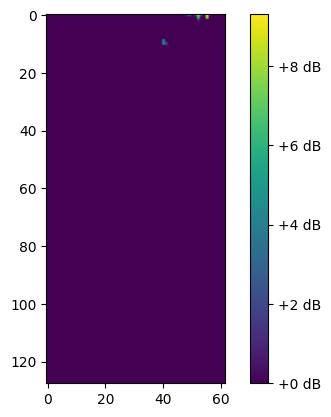

../../datasets/birdsongs-combined/train_audio/rerswa1/XC381917.ogg, mean=np.float32(1.0248283), var=np.float32(27.434319)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC381917.ogg, mean=np.float32(3.4412742), var=np.float32(82.60322)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC381917.ogg, mean=np.float32(4.487346), var=np.float32(120.29973)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC381917.ogg, mean=np.float32(1.0824786), var=np.float32(31.327314)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC381917.ogg, mean=np.float32(0.009682822), var=np.float32(0.05777185)


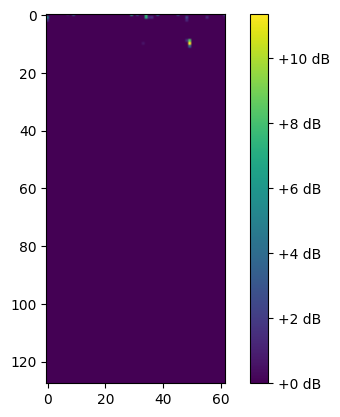

../../datasets/birdsongs-combined/train_audio/rerswa1/XC381917.ogg, mean=np.float32(0.035257287), var=np.float32(0.40772262)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC381917.ogg, mean=np.float32(0.038962442), var=np.float32(0.6093905)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC381917.ogg, mean=np.float32(0.07748231), var=np.float32(0.63704056)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC381917.ogg, mean=np.float32(1.6945868), var=np.float32(42.098114)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC381917.ogg, mean=np.float32(4.5637317), var=np.float32(119.75206)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC381917.ogg, mean=np.float32(1.0831722), var=np.float32(33.089653)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC381917.ogg, mean=np.float32(0.006057555), var=np.float32(0.032105677)


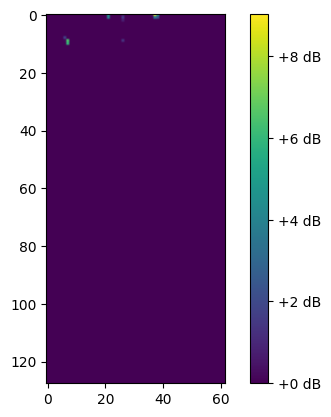

../../datasets/birdsongs-combined/train_audio/rerswa1/XC381917.ogg, mean=np.float32(0.0), var=np.float32(0.0)


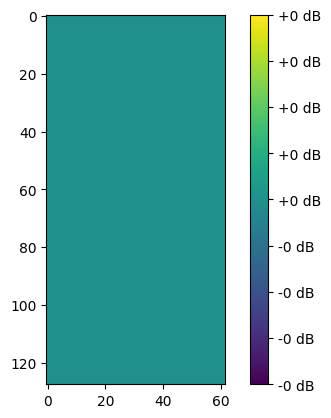

../../datasets/birdsongs-combined/train_audio/rerswa1/XC381917.ogg, mean=np.float32(0.0016562801), var=np.float32(0.0064026094)


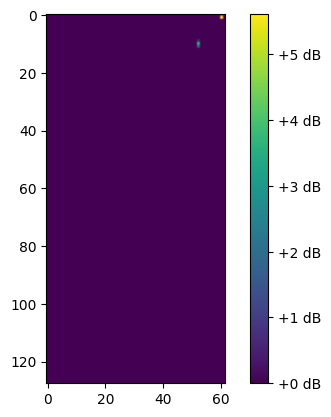

../../datasets/birdsongs-combined/train_audio/rerswa1/XC381917.ogg, mean=np.float32(0.0027568683), var=np.float32(0.012451716)


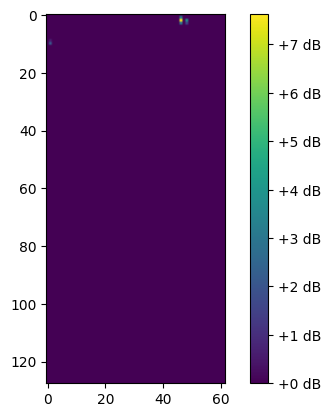

../../datasets/birdsongs-combined/train_audio/rerswa1/XC381917.ogg, mean=np.float32(2.8926034), var=np.float32(89.8086)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC381917.ogg, mean=np.float32(2.3678422), var=np.float32(63.71539)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC381917.ogg, mean=np.float32(3.5009017), var=np.float32(100.45892)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC381917.ogg, mean=np.float32(0.7245332), var=np.float32(13.645549)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC381917.ogg, mean=np.float32(4.6432495), var=np.float32(105.535805)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC381917.ogg, mean=np.float32(2.5970418), var=np.float32(68.10295)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC381917.ogg, mean=np.float32(1.8797686), var=np.float32(42.88308)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC381917.ogg, mean=np.float32(0.71533746), var=np.float32(13.010187)
../../datasets/birdsongs-co

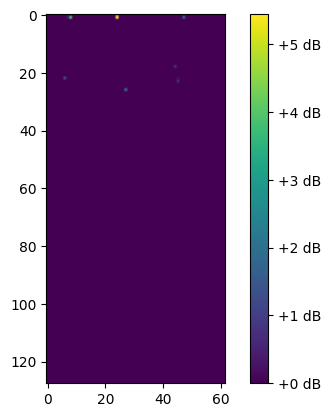

../../datasets/birdsongs-combined/train_audio/rerswa1/XC381917.ogg, mean=np.float32(0.0077404147), var=np.float32(0.028939215)


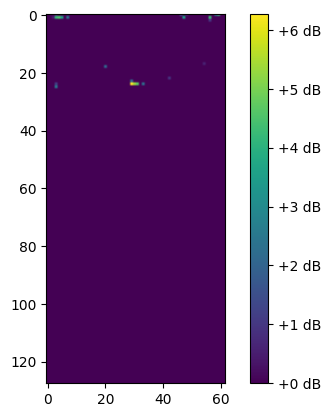

../../datasets/birdsongs-combined/train_audio/rerswa1/XC381917.ogg, mean=np.float32(0.919051), var=np.float32(22.599848)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC381917.ogg, mean=np.float32(3.9812903), var=np.float32(74.05759)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC381917.ogg, mean=np.float32(0.18990147), var=np.float32(2.369179)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC381917.ogg, mean=np.float32(0.13009687), var=np.float32(1.2299572)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC381917.ogg, mean=np.float32(0.0042970297), var=np.float32(0.015842548)


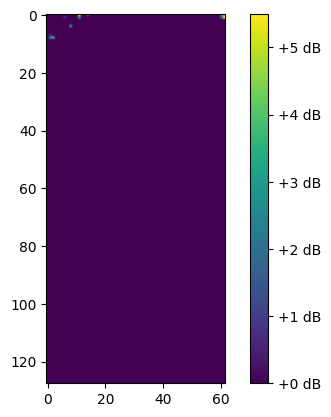

../../datasets/birdsongs-combined/train_audio/rerswa1/XC381917.ogg, mean=np.float32(0.018977331), var=np.float32(0.13946825)


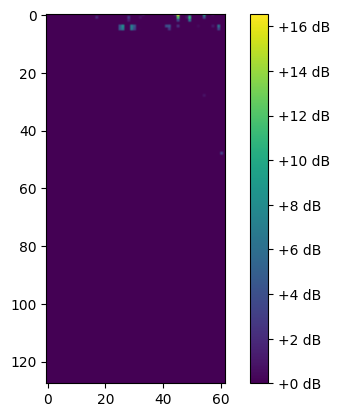

../../datasets/birdsongs-combined/train_audio/rerswa1/XC381917.ogg, mean=np.float32(2.5834677), var=np.float32(55.021267)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC381917.ogg, mean=np.float32(4.726741), var=np.float32(99.19483)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC381917.ogg, mean=np.float32(0.76902306), var=np.float32(13.299957)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC381917.ogg, mean=np.float32(6.0942965), var=np.float32(113.41791)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC381917.ogg, mean=np.float32(0.3092634), var=np.float32(4.5760894)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC381917.ogg, mean=np.float32(0.23391294), var=np.float32(2.6774068)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC381917.ogg, mean=np.float32(2.9164562), var=np.float32(57.33163)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC381917.ogg, mean=np.float32(3.6088989), var=np.float32(70.81583)
../../datasets/birdsongs-c

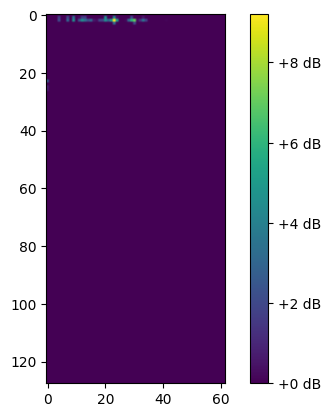

Folder 2/10 - rerswa1:  87%|████████▋ | 58/67 [00:07<00:02,  3.17it/s]

../../datasets/birdsongs-combined/train_audio/rerswa1/XC193686.ogg, mean=np.float32(4.268003), var=np.float32(99.185135)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC193686.ogg, mean=np.float32(5.1003), var=np.float32(112.326935)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC193686.ogg, mean=np.float32(5.9492173), var=np.float32(119.04572)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC193686.ogg, mean=np.float32(2.7251713), var=np.float32(60.516754)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC193686.ogg, mean=np.float32(1.9822329), var=np.float32(52.52517)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC193686.ogg, mean=np.float32(4.763099), var=np.float32(119.232414)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC193686.ogg, mean=np.float32(3.2503874), var=np.float32(86.36101)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC193686.ogg, mean=np.float32(3.226882), var=np.float32(70.977425)
../../datasets/birdsongs-combi

Folder 2/10 - rerswa1: 100%|██████████| 67/67 [00:08<00:00,  8.08it/s]


../../datasets/birdsongs-combined/train_audio/rerswa1/XC423980.ogg, mean=np.float32(4.576486), var=np.float32(72.12214)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC423980.ogg, mean=np.float32(3.1032634), var=np.float32(53.188473)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC423980.ogg, mean=np.float32(3.0956476), var=np.float32(62.776474)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC423980.ogg, mean=np.float32(1.3463258), var=np.float32(9.439042)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC423980.ogg, mean=np.float32(4.317689), var=np.float32(84.29705)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC423980.ogg, mean=np.float32(3.2993605), var=np.float32(30.416336)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC423980.ogg, mean=np.float32(2.3027031), var=np.float32(36.097324)
../../datasets/birdsongs-combined/train_audio/rerswa1/XC423980.ogg, mean=np.float32(1.8537507), var=np.float32(12.546055)
../../datasets/birdsongs-comb

Folder 3/10 - cobtan1:   8%|▊         | 2/26 [00:00<00:01, 13.58it/s]

../../datasets/birdsongs-combined/train_audio/cobtan1/XC250643.ogg, mean=np.float32(0.8413844), var=np.float32(9.423991)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC250643.ogg, mean=np.float32(0.98591226), var=np.float32(16.763443)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC250643.ogg, mean=np.float32(1.3458861), var=np.float32(27.477964)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC250643.ogg, mean=np.float32(1.1317288), var=np.float32(24.155363)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC250643.ogg, mean=np.float32(1.4664754), var=np.float32(30.00162)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC250643.ogg, mean=np.float32(1.4132166), var=np.float32(26.15176)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC250643.ogg, mean=np.float32(2.1797185), var=np.float32(42.86774)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC250643.ogg, mean=np.float32(1.606577), var=np.float32(30.404488)
../../datasets/birdsongs-com

Folder 3/10 - cobtan1:  23%|██▎       | 6/26 [00:00<00:01, 16.86it/s]

../../datasets/birdsongs-combined/train_audio/cobtan1/XC131764.ogg, mean=np.float32(4.0081367), var=np.float32(42.748184)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC131764.ogg, mean=np.float32(4.6396556), var=np.float32(63.272873)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC131764.ogg, mean=np.float32(4.5174313), var=np.float32(54.004196)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC131764.ogg, mean=np.float32(3.7708292), var=np.float32(36.31528)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC131764.ogg, mean=np.float32(5.751838), var=np.float32(46.70961)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC131764.ogg, mean=np.float32(3.1760638), var=np.float32(35.421474)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC131764.ogg, mean=np.float32(2.3646402), var=np.float32(39.634212)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC131764.ogg, mean=np.float32(1.6375263), var=np.float32(20.706846)
../../datasets/birdsongs-co

Folder 3/10 - cobtan1:  42%|████▏     | 11/26 [00:00<00:00, 16.58it/s]

../../datasets/birdsongs-combined/train_audio/cobtan1/XC250641.ogg, mean=np.float32(5.3488717), var=np.float32(58.794174)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC250641.ogg, mean=np.float32(5.412348), var=np.float32(58.228233)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC250641.ogg, mean=np.float32(6.1273084), var=np.float32(69.97045)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC250641.ogg, mean=np.float32(6.156799), var=np.float32(68.64826)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC250641.ogg, mean=np.float32(5.7629976), var=np.float32(62.672054)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC250641.ogg, mean=np.float32(6.0324955), var=np.float32(67.638916)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC250641.ogg, mean=np.float32(6.2107697), var=np.float32(69.50737)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC250641.ogg, mean=np.float32(6.4055796), var=np.float32(72.300125)
../../datasets/birdsongs-comb

Folder 3/10 - cobtan1:  54%|█████▍    | 14/26 [00:00<00:00, 19.49it/s]

../../datasets/birdsongs-combined/train_audio/cobtan1/XC233093.ogg, mean=np.float32(3.7768273), var=np.float32(73.96795)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC233093.ogg, mean=np.float32(2.7267258), var=np.float32(38.631283)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC233093.ogg, mean=np.float32(6.05646), var=np.float32(147.50533)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC233093.ogg, mean=np.float32(4.2549157), var=np.float32(89.91026)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC233093.ogg, mean=np.float32(3.3950567), var=np.float32(74.68202)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC499340.ogg, mean=np.float32(2.4288955), var=np.float32(84.03765)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC499340.ogg, mean=np.float32(0.19579203), var=np.float32(1.4294866)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC499340.ogg, mean=np.float32(0.50475013), var=np.float32(4.5345473)
../../datasets/birdsongs-com

Folder 3/10 - cobtan1:  77%|███████▋  | 20/26 [00:01<00:00, 21.77it/s]

../../datasets/birdsongs-combined/train_audio/cobtan1/XC73365.ogg, mean=np.float32(3.4341598), var=np.float32(113.90236)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC73365.ogg, mean=np.float32(2.3376234), var=np.float32(71.73074)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC73365.ogg, mean=np.float32(2.8461466), var=np.float32(80.253815)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC73365.ogg, mean=np.float32(2.4313486), var=np.float32(59.907516)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC73365.ogg, mean=np.float32(2.4120455), var=np.float32(73.12099)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC73365.ogg, mean=np.float32(2.6024468), var=np.float32(74.882324)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC73365.ogg, mean=np.float32(2.013577), var=np.float32(59.584312)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC73365.ogg, mean=np.float32(3.1264963), var=np.float32(81.682724)
../../datasets/birdsongs-combined/t

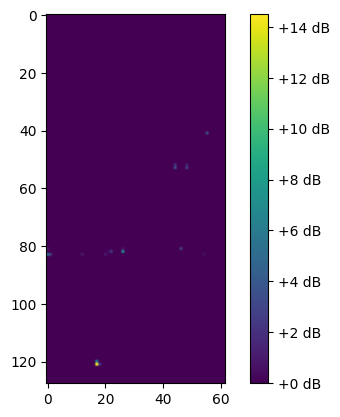

../../datasets/birdsongs-combined/train_audio/cobtan1/XC277136.ogg, mean=np.float32(0.011024557), var=np.float32(0.085948154)


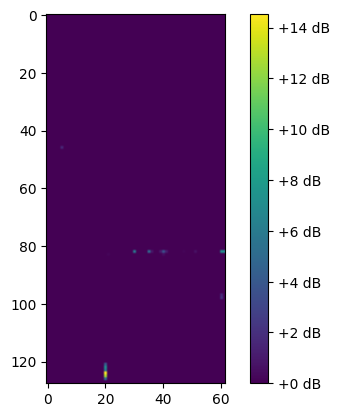

../../datasets/birdsongs-combined/train_audio/cobtan1/XC277136.ogg, mean=np.float32(0.09252418), var=np.float32(0.63965404)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277136.ogg, mean=np.float32(0.048434354), var=np.float32(0.50668776)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277136.ogg, mean=np.float32(0.31893706), var=np.float32(4.5753202)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277136.ogg, mean=np.float32(0.18924025), var=np.float32(2.6654305)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277136.ogg, mean=np.float32(0.30867288), var=np.float32(6.9483066)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277136.ogg, mean=np.float32(0.15450114), var=np.float32(2.7381873)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277136.ogg, mean=np.float32(0.26028278), var=np.float32(6.2904997)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277136.ogg, mean=np.float32(0.13364777), var=np.float32(2.4376276)
../../dataset

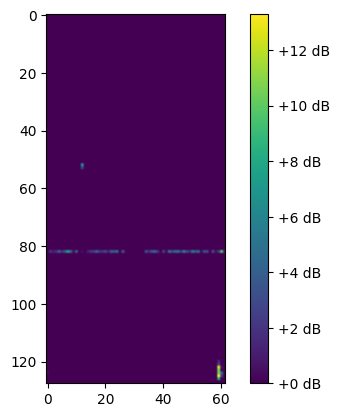

../../datasets/birdsongs-combined/train_audio/cobtan1/XC277136.ogg, mean=np.float32(0.069669075), var=np.float32(0.49785098)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277136.ogg, mean=np.float32(0.09908095), var=np.float32(1.0560596)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277136.ogg, mean=np.float32(0.080221005), var=np.float32(0.8092437)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277136.ogg, mean=np.float32(0.11112012), var=np.float32(1.4120861)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277136.ogg, mean=np.float32(0.14717257), var=np.float32(2.302823)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277136.ogg, mean=np.float32(0.13513035), var=np.float32(1.9500387)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277136.ogg, mean=np.float32(0.053061716), var=np.float32(0.7148292)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277136.ogg, mean=np.float32(0.0028909196), var=np.float32(0.00670273)


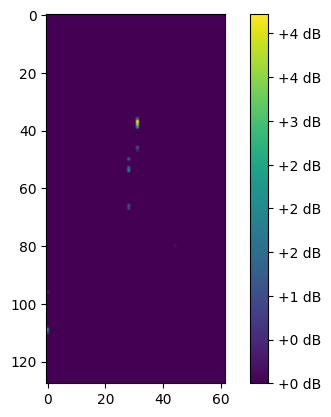

Folder 3/10 - cobtan1:  88%|████████▊ | 23/26 [00:01<00:00,  9.99it/s]

../../datasets/birdsongs-combined/train_audio/cobtan1/XC609954.ogg, mean=np.float32(0.48703152), var=np.float32(9.53313)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC609954.ogg, mean=np.float32(0.8922333), var=np.float32(19.69085)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC609954.ogg, mean=np.float32(1.7971697), var=np.float32(42.294247)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC609954.ogg, mean=np.float32(0.7946028), var=np.float32(21.740852)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC609954.ogg, mean=np.float32(1.4223813), var=np.float32(44.10981)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC609954.ogg, mean=np.float32(0.57127154), var=np.float32(12.77976)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC609954.ogg, mean=np.float32(2.3966358), var=np.float32(69.51354)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC609954.ogg, mean=np.float32(0.64764637), var=np.float32(17.305466)
../../datasets/birdsongs-co

Folder 3/10 - cobtan1:  88%|████████▊ | 23/26 [00:01<00:00,  9.99it/s]

../../datasets/birdsongs-combined/train_audio/cobtan1/XC607802.ogg, mean=np.float32(1.5843531), var=np.float32(38.112972)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC607802.ogg, mean=np.float32(1.8409691), var=np.float32(41.980415)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC607802.ogg, mean=np.float32(1.4184847), var=np.float32(36.352074)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC607802.ogg, mean=np.float32(1.4032123), var=np.float32(33.601334)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC607802.ogg, mean=np.float32(1.6022207), var=np.float32(43.34361)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC607802.ogg, mean=np.float32(1.3078415), var=np.float32(35.53624)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC607802.ogg, mean=np.float32(1.543543), var=np.float32(39.81605)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC607802.ogg, mean=np.float32(2.8487287), var=np.float32(78.31298)
../../datasets/birdsongs-comb

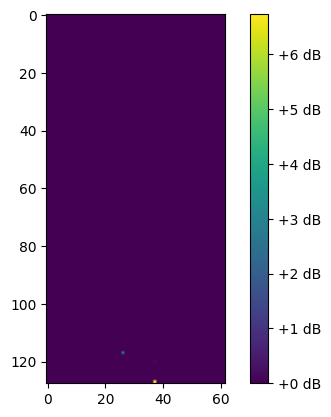

../../datasets/birdsongs-combined/train_audio/cobtan1/XC259728.ogg, mean=np.float32(0.0016702149), var=np.float32(0.014717098)


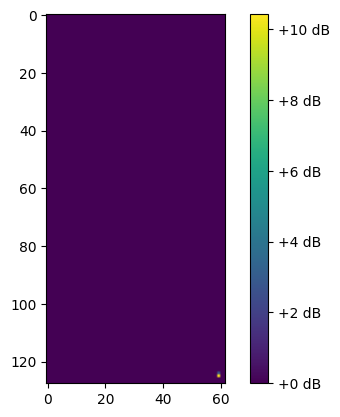

../../datasets/birdsongs-combined/train_audio/cobtan1/XC259728.ogg, mean=np.float32(0.0140646435), var=np.float32(0.16188422)


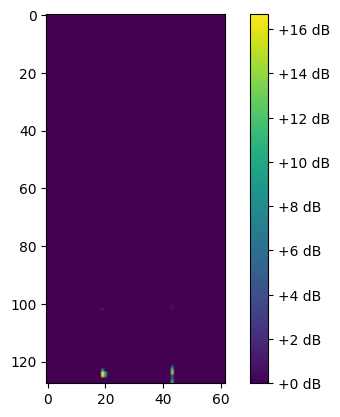

../../datasets/birdsongs-combined/train_audio/cobtan1/XC259728.ogg, mean=np.float32(0.057166122), var=np.float32(0.7806403)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC259728.ogg, mean=np.float32(0.095197976), var=np.float32(2.3727357)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC259728.ogg, mean=np.float32(0.24483377), var=np.float32(6.400854)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC259728.ogg, mean=np.float32(1.008317), var=np.float32(33.62881)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC259728.ogg, mean=np.float32(1.2321026), var=np.float32(42.30334)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC259728.ogg, mean=np.float32(1.1771982), var=np.float32(36.69674)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC259728.ogg, mean=np.float32(0.836508), var=np.float32(27.76414)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC259728.ogg, mean=np.float32(0.38473985), var=np.float32(10.728146)
../../datasets/birdsongs-

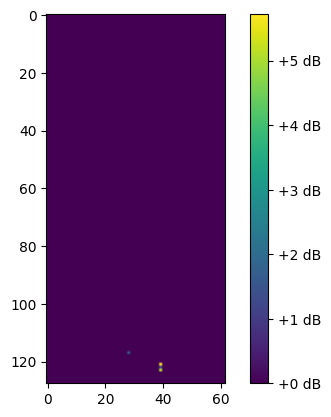

../../datasets/birdsongs-combined/train_audio/cobtan1/XC259728.ogg, mean=np.float32(0.002432847), var=np.float32(0.02683745)


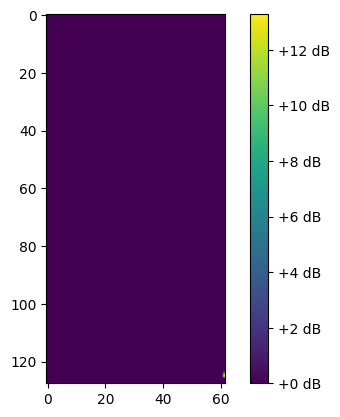

../../datasets/birdsongs-combined/train_audio/cobtan1/XC259728.ogg, mean=np.float32(0.015619595), var=np.float32(0.19597739)


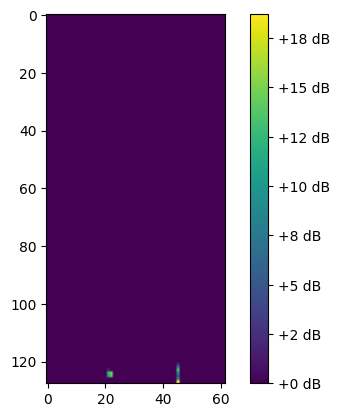

Folder 3/10 - cobtan1:  96%|█████████▌| 25/26 [00:02<00:00,  5.96it/s]

../../datasets/birdsongs-combined/train_audio/cobtan1/XC259728.ogg, mean=np.float32(0.061566956), var=np.float32(0.8338184)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC259728.ogg, mean=np.float32(0.094314195), var=np.float32(2.3118572)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC259728.ogg, mean=np.float32(0.24597761), var=np.float32(6.5574803)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC259728.ogg, mean=np.float32(0.7440644), var=np.float32(23.406021)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC259728.ogg, mean=np.float32(1.3214923), var=np.float32(45.960957)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC259728.ogg, mean=np.float32(1.3471019), var=np.float32(41.559067)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC259728.ogg, mean=np.float32(0.85993266), var=np.float32(28.468983)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC259728.ogg, mean=np.float32(0.38189024), var=np.float32(10.914723)
../../datasets/bi

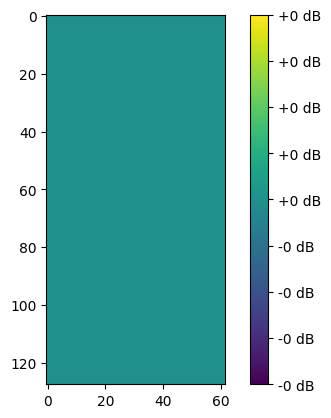

../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(0.3611296), var=np.float32(8.033621)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(2.0028129), var=np.float32(55.821888)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(3.3776994), var=np.float32(94.92853)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(0.40570942), var=np.float32(6.7469573)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(0.0017009762), var=np.float32(0.0036678596)


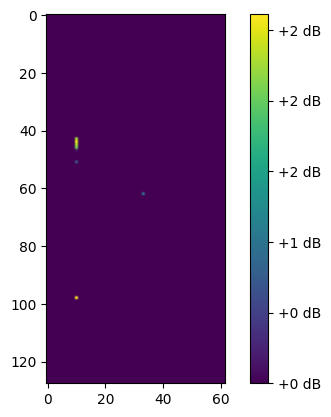

../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(0.0), var=np.float32(0.0)


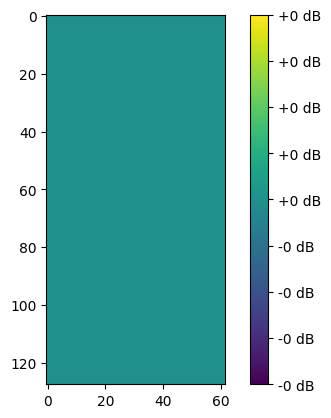

../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(0.0), var=np.float32(0.0)


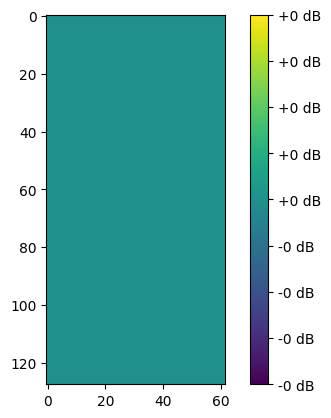

../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(0.0018855209), var=np.float32(0.008613967)


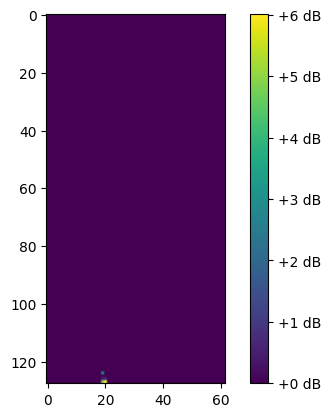

../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(0.01829636), var=np.float32(0.30513772)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(0.07923263), var=np.float32(1.7156659)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(0.9284455), var=np.float32(21.826384)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(4.6483674), var=np.float32(144.16243)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(0.24052064), var=np.float32(3.9870136)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(0.006838209), var=np.float32(0.09813305)


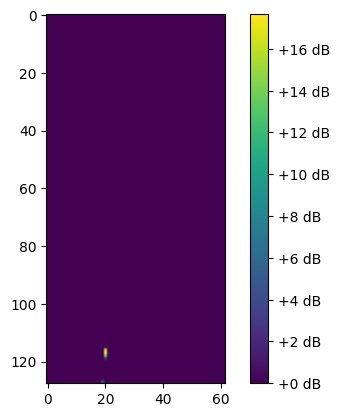

../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(0.056894388), var=np.float32(0.85042137)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(0.6741661), var=np.float32(16.534298)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(3.1472669), var=np.float32(102.09479)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(3.2445688), var=np.float32(94.16099)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(1.1483228), var=np.float32(27.080574)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(0.00015069016), var=np.float32(0.00013535043)


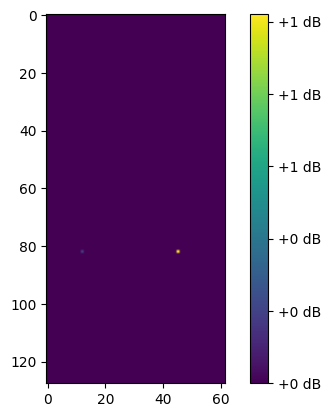

../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(0.00048835337), var=np.float32(0.00050075434)


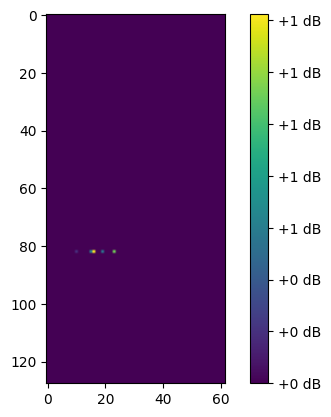

../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(0.005344884), var=np.float32(0.03541601)


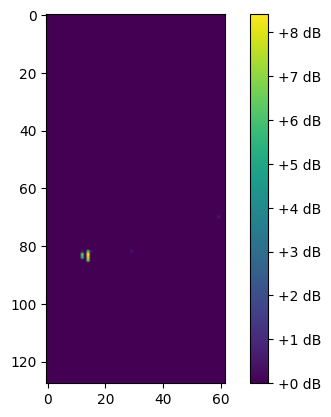

../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(4.468185e-06), var=np.float32(1.5841974e-07)


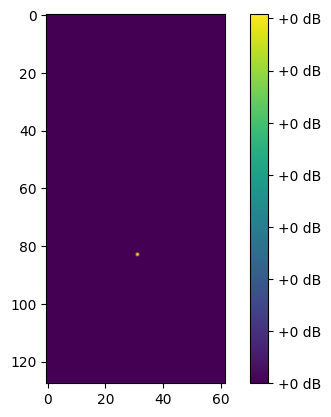

../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(0.052455317), var=np.float32(0.59898496)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(0.12658817), var=np.float32(2.3988776)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(0.00020689926), var=np.float32(0.00033967584)


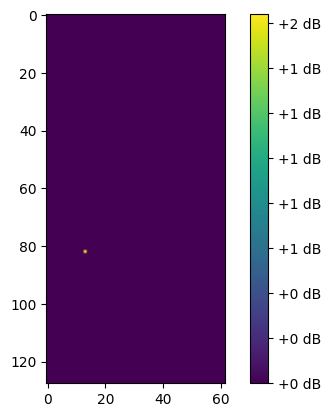

../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(0.00087565114), var=np.float32(0.004107898)


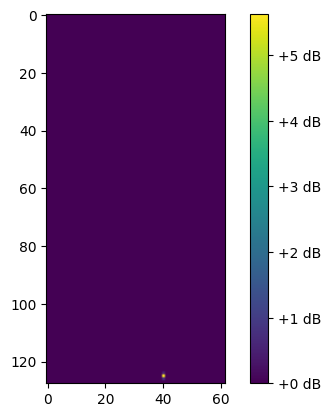

../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(0.030370822), var=np.float32(0.45427012)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(0.27447614), var=np.float32(7.387833)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(0.3277638), var=np.float32(7.4363246)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(2.4723814), var=np.float32(78.47206)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(0.17806356), var=np.float32(2.9089346)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(0.0097971), var=np.float32(0.055793796)


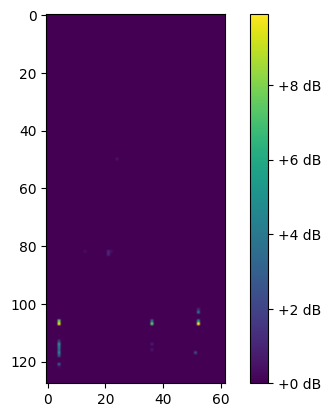

../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(0.0014400987), var=np.float32(0.004949589)


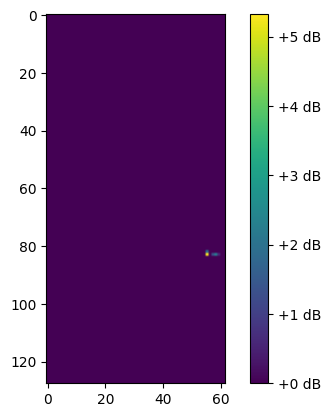

../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(0.0007657438), var=np.float32(0.0010817269)


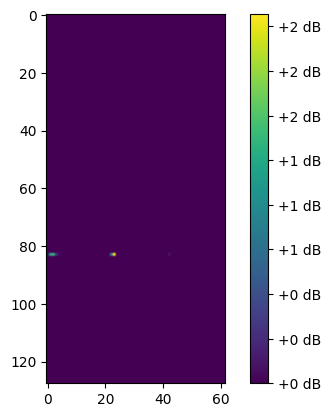

../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(0.00711734), var=np.float32(0.041915562)


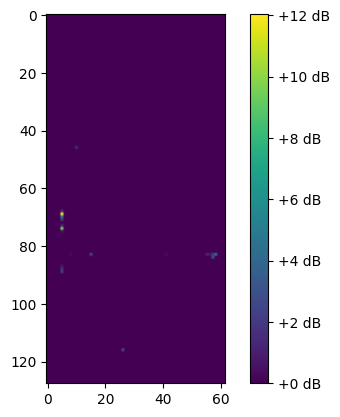

../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(0.10451499), var=np.float32(1.4166094)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(0.1962973), var=np.float32(3.774114)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(1.0682656), var=np.float32(29.859716)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(4.3851733), var=np.float32(129.7455)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(0.29610875), var=np.float32(8.680004)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(0.016836448), var=np.float32(0.1196256)


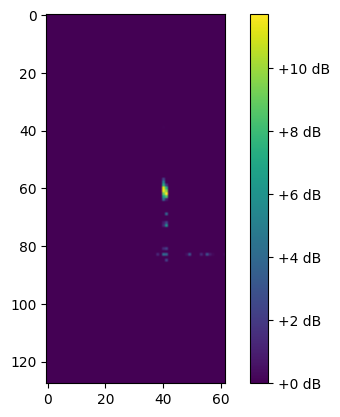

../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(0.0030167869), var=np.float32(0.009220996)


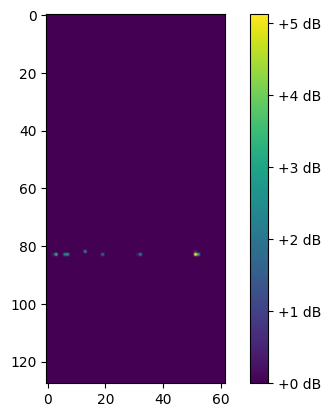

../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(0.013823872), var=np.float32(0.15154341)


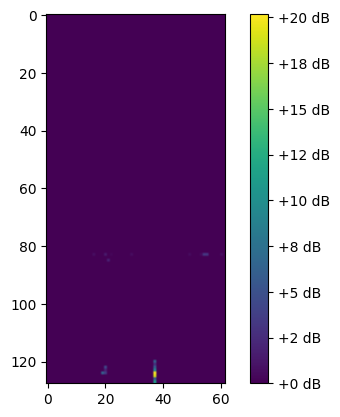

../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(0.015858928), var=np.float32(0.13474634)


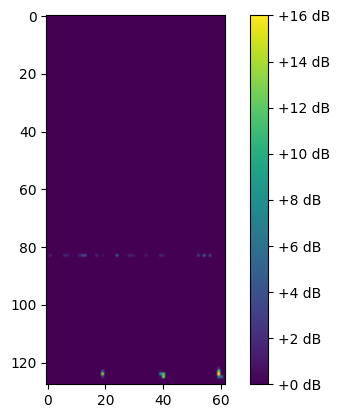

../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(0.0966331), var=np.float32(1.7034007)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(0.75951684), var=np.float32(22.431774)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(4.3331814), var=np.float32(139.89279)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(2.0323915), var=np.float32(59.58978)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(0.045535695), var=np.float32(0.5341713)
../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(0.0), var=np.float32(0.0)


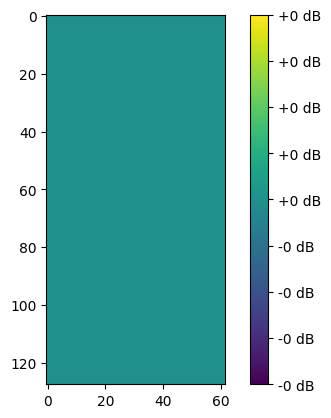

../../datasets/birdsongs-combined/train_audio/cobtan1/XC277140.ogg, mean=np.float32(3.8901646e-05), var=np.float32(1.2008334e-05)


Folder 3/10 - cobtan1:  96%|█████████▌| 25/26 [00:05<00:00,  4.85it/s]


KeyboardInterrupt: 

In [28]:
reset_seed()

folder_df = get_random_folders_filtered(
    base_path, 
    split_interval_secs=split_interval_secs, 
    sample_rate=sample_rate,
    total_folders=total_folders,
    min_rating=min_rating,
    max_files_per_folder=max_files_per_folder
)

In [7]:
folder_df.head()

,folder,file,mel_spec,mel_spec_shape
0,dowwoo,XC332244.mp3,"[[-18.327545, -18.327545, -18.327545, -18.3275...","(128, 62)"
1,dowwoo,XC332244.mp3,"[[-18.327545, -18.327545, -18.327545, -18.3275...","(128, 62)"
2,dowwoo,XC466635.mp3,"[[-39.40262, 4.5772038, 4.6402555, 4.8710995, ...","(128, 62)"
3,dowwoo,XC476564.ogg,"[[-25.170895, -25.170895, -25.170895, -25.1708...","(128, 62)"
4,dowwoo,XC476564.ogg,"[[-25.170895, -25.170895, -25.170895, -25.1708...","(128, 62)"


In [8]:
folder_df["mel_spec_shape"].value_counts()

mel_spec_shape
(128, 62)    50299
Name: count, dtype: int64

In [9]:
folder_df["folder"].value_counts()

folder
redcro     6796
barswa     4574
spotow     2696
combuz1    2695
banswa     2606
compau     2461
grycat     1971
bkskit1    1885
combul2    1878
eucdov     1773
comyel     1596
logshr     1404
rerswa1    1062
litegr      949
indbun      925
cubthr      867
scbwre1     801
yehbla      765
pirfly1     719
verdin      678
whiwre1     670
whbman1     603
oliwoo1     590
cobtan1     563
leater1     541
brncre      541
yehcar1     529
mitpar      491
brnjay      484
annhum      472
dowwoo      449
buwwar      413
phaino      407
blhpar1     404
mawthr1     392
sheowl      388
peflov      368
royter1     365
bkbmag1     362
piebus1     258
ocbfly1     247
amtspa      233
lotduc      213
insowl1     212
yebsap      211
comloo      191
amepip      185
zebdov      172
blkfra      142
brubru1     102
Name: count, dtype: int64

In [10]:
print("sound clips BEFORE any sampling:", len(folder_df))

sound clips BEFORE any sampling: 50299


In [11]:
len(folder_df["folder"].unique())

50

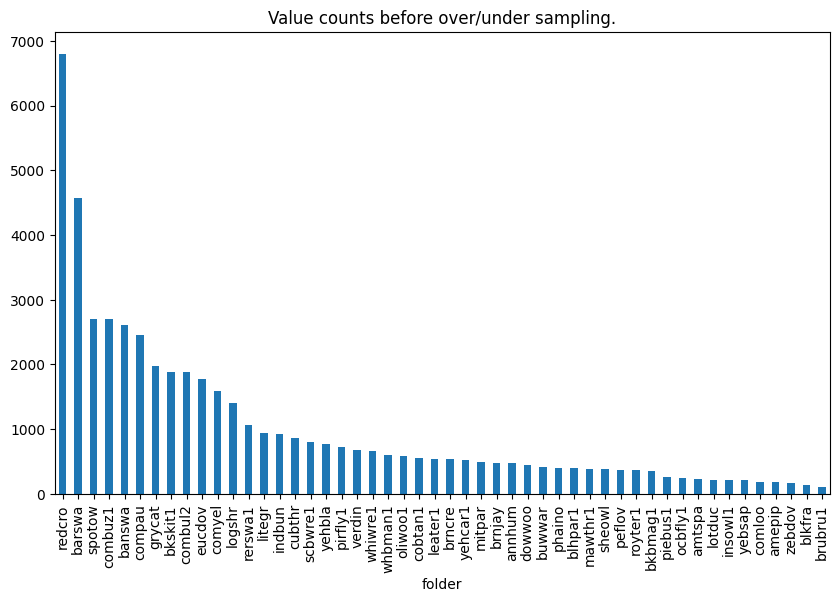

In [12]:
plt.figure(figsize=(max(10, total_folders // 8), 6))
folder_df["folder"].value_counts().plot.bar(title="Value counts before over/under sampling.")
plt.show()

In [13]:
# apply random undersampling OR oversampling

reset_seed()

if sampling_technique == "under":
    # random "naive" undersampling
    # delete random rows from all classes except minority class(es)
    min_folder_count = min(folder_df["folder"].value_counts())

    indices_to_keep = np.array([])

    for f in folder_df["folder"].unique():
        indices_to_keep = np.concat([np.random.choice(folder_df[folder_df["folder"] == f].index, size=min_folder_count), indices_to_keep])

    folder_df = folder_df.loc[indices_to_keep]
    folder_df.reset_index(drop=True, inplace=True)

if sampling_technique == "over":
    ros = RandomOverSampler(random_state=1368)

    # print how much each class will increase by (relative to its current size)
    max_folder = max(folder_df["folder"].value_counts())
    for folder, count in folder_df["folder"].value_counts().sort_values(ascending=True).items():
        print(f"{folder} will increase by {round((max_folder / count - 1) * 100, 2)}%")

    folder_df = pd.concat(ros.fit_resample(folder_df.drop("folder", axis=1), folder_df["folder"]), axis=1)
    # moves "folder" to other side of df but shouldn't affect anything

if sampling_technique == "median":
    # take the median value of folder counts
    # under sample all above the median
    # over smaple all below the median

    ros = RandomOverSampler(random_state=1368)
    median_folder_count = round(folder_df["folder"].value_counts().median())
    indices_to_keep = np.array([])

    print("median:", median_folder_count)

    for f in folder_df["folder"].unique():
        folder_length = len(folder_df[folder_df["folder"] == f])
        if folder_length > median_folder_count:
            indices_to_keep = np.concat([np.random.choice(folder_df[folder_df["folder"] == f].index, size=median_folder_count), indices_to_keep])
        else:
            indices_to_keep = np.concat([folder_df[folder_df["folder"] == f].index, indices_to_keep])
        
    folder_df = folder_df.loc[indices_to_keep]
    folder_df.reset_index(drop=True, inplace=True)
    
    folder_df = pd.concat(ros.fit_resample(folder_df.drop("folder", axis=1), folder_df["folder"]), axis=1)

median: 541


<Axes: title={'center': 'Value counts after median sampling.'}, xlabel='folder'>

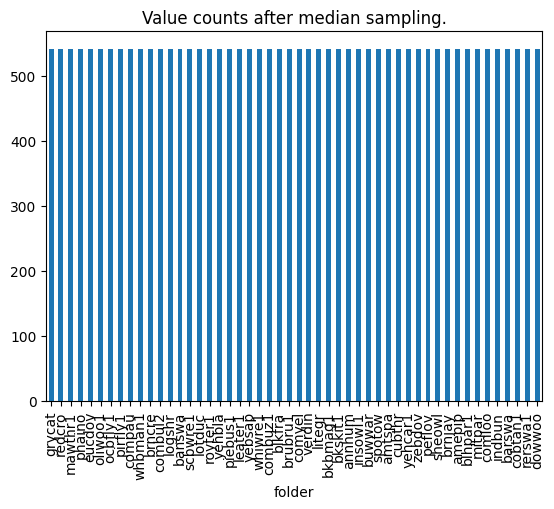

In [14]:
folder_df["folder"].value_counts().plot.bar(title=f"Value counts after {sampling_technique} sampling.")

In [15]:
print("sound clips AFTER sampling:", len(folder_df))

sound clips AFTER sampling: 27050


(128, 62)


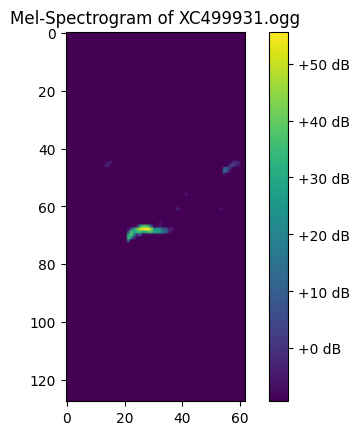

(128, 62)


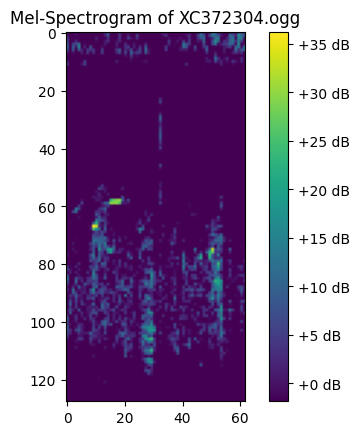

(128, 62)


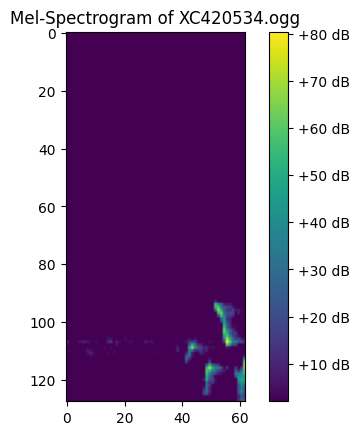

In [16]:
# plot 5 random mel spectrograms
# checks for consistency in scaling and whatnot

reset_seed()

sample_spec_indices = random.sample(folder_df.index.tolist(), k=3)

for i in sample_spec_indices:
    row = folder_df.iloc[i]
    
    print(row["mel_spec_shape"])
    
    plt.figure()
    plt.imshow(row["mel_spec"])
    plt.title(f"Mel-Spectrogram of {'/'.join(row['file'].split('/')[-2:])}")
    plt.colorbar(format='%+2.0f dB')
    plt.show()

del row

In [17]:
# input shape needs to be AxBxCxD
# A = list of files
# B = depth of each one (currently just 1, as it only contains 1 value. if colours are used then maybe up it to 3)
# CxD = input width/height (128x626 etc)
if "mel_spec" in folder_df.columns:
    print("step 1")
    x = folder_df["mel_spec"]
    print("step 2")
    folder_df.drop("mel_spec", axis=1, inplace=True)
    print("step 3")
    x = np.stack(x)
    print("step 4")
    x = torch.from_numpy(x)
    print("step 5")
    x = x.reshape(x.shape[0], 1, x.shape[1], x.shape[2])
    print("step 6")
    x = x.to(device)

print("step 7")
le = LabelEncoder()
print("step 8")
y = torch.LongTensor(le.fit_transform(folder_df["folder"]))
print("step 9")
y = y.to(device)

step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9


In [18]:
reset_seed()

x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True, test_size=test_size, random_state=1368)

del x, y

In [19]:
# iteration 3.0

class TestModel(nn.Module):
    global folder_df

    def __init__(self, input_shape: torch.Size, dropout_rate: float = 0):
        super().__init__()

        total_output_classes = len(folder_df["folder"].unique())

        # input shape should be some list/tuple of length 4
        if len(input_shape) != 4: return Exception("Input shape is not AxBxCxD.")
        
        A = input_shape[0]
        B = input_shape[1]
        C = input_shape[2]
        D = input_shape[3]

        self.relu = nn.ReLU() # relu does not have trainable parameters, thus, can be reused

        self.conv1 = nn.Conv2d(in_channels=B, out_channels=10, kernel_size=(3, 3))
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.drop1 = nn.Dropout(p=dropout_rate)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3))
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.drop2 = nn.Dropout(p=dropout_rate)
        self.flat = nn.Flatten()

        flatten_nodes = 10 * ((((C - 2) // 2) - 2) // 2) * ((((D - 2) // 2) - 2) // 2)
        
        self.norm = nn.BatchNorm1d(num_features=flatten_nodes)
        self.linear1 = nn.Linear(in_features=flatten_nodes, out_features=1024)
        self.linear2 = nn.Linear(in_features=1024, out_features=512)
        self.linear3 = nn.Linear(in_features=512, out_features=128) 
        self.output = nn.Linear(in_features=128, out_features=total_output_classes)

    def forward(self, x):
        # define calculations here
        x = self.conv1(x)
        x = self.relu(x)

        x = self.pool1(x)
        x = self.drop1(x)

        x = self.conv2(x)
        x = self.relu(x)

        x = self.pool2(x)
        x = self.drop2(x)

        x = self.flat(x)
        x = self.norm(x)

        x = self.linear1(x)
        x = self.relu(x)

        x = self.linear2(x)
        x = self.relu(x)

        x = self.linear3(x)
        x = self.relu(x)

        x = self.output(x)
        x = self.relu(x)

        return x

In [20]:
# model: the model to train
# loss_fn: the loss function to update weights
# optimizer: the optimiser function to affect rate of change
# epochs: number of epochs to train the model over
# batch_size: samples to train x_train and y_train to avoid memory issues
# save_best_to_file: save model with highest test accuracy to models/ folder.
# experimental: whether to end training after 5 consecutive runs of no higher test accuracy.
#       - training ends when either [epochs] epochs have been run, *OR* if 5 consecutive runs do not improve test accuracy from previous best.

def train_model(model, loss_fn, optimizer, epochs, batch_size, save_best_to_file = False, experimental = False):
    global x_train, y_train
    batch_indices = np.linspace(0, len(x_train), int(len(x_train) / batch_size), dtype="int")

    train_loss_hist = []
    train_acc_hist = []
    test_acc_hist = []

    best_test_acc = 0
    best_model = None

    experimental_counter = 0

    for epoch in range(1, epochs + 1):
        model.train()

        train_acc = 0
        
        for i in range(len(batch_indices) - 1):
            start_index = batch_indices[i]
            stop_index = batch_indices[i + 1]

            x_batch = x_train[start_index:stop_index]
            y_batch = y_train[start_index:stop_index]

            x_batch, y_batch = shuffle(x_batch, y_batch)

            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            train_acc += sum(torch.argmax(y_pred, dim=1) == y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_acc = train_acc * 100 / len(y_train)

        model.eval()
        test_acc = sum(torch.argmax(model(x_test), dim=1) == y_test) * 100 / len(y_test)

        print(f"Epoch {epoch}: train loss = {loss:.04f}, train acc = {train_acc:.02f}%, test acc = {test_acc:.02f}% {"!!" if test_acc > best_test_acc else ""}")

        train_loss_hist.append(float(loss.cpu().detach().numpy()))
        train_acc_hist.append(float(train_acc.cpu().detach().numpy()))
        test_acc_hist.append(float(test_acc.cpu().detach().numpy()))

        if experimental:
            experimental_counter += 1

        if test_acc > best_test_acc:
            experimental_counter = 0
            best_test_acc = test_acc
            
            # overwrite best model with new best model
            best_model = copy.deepcopy(model.state_dict())

        if experimental_counter == experimental_counter_limit:
            print(f"Experimental Mode ended the training early, as the testing accuracy had not increased over {experimental_counter_limit} consecutive epochs.")
            break
        
    if save_best_to_file:
        model_save_path = "models/"
        if not os.path.exists(model_save_path): os.mkdir(model_save_path)
        file_number = len(os.listdir(model_save_path)) + 1
        file_name = f"best_model_{file_number:>03}"
        best_model_path = model_save_path + file_name + ".pth"

        torch.save(best_model, best_model_path)

    plt.figure(figsize=(12,8))
    pd.Series(train_acc_hist).plot.line(label="Train", color="blue")
    pd.Series(test_acc_hist).plot.line(label="Test", color="red")
    plt.legend()
    plt.ylim((0, 100))
    plt.yticks(np.arange(0, 101, 10))
    plt.title(f"Convolutional Neural Network on {len(folder_df)} sound clips over {len(folder_df["folder"].unique())} folders.")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.grid(axis="y")
    plt.show()

    return train_loss_hist, train_acc_hist, test_acc_hist, best_model

4908148
Epoch 1: train loss = 3.4305, train acc = 9.36%, test acc = 10.78% !!
Epoch 2: train loss = 2.8962, train acc = 23.44%, test acc = 18.48% !!
Epoch 3: train loss = 2.5008, train acc = 34.62%, test acc = 26.23% !!
Epoch 4: train loss = 2.2093, train acc = 42.39%, test acc = 31.76% !!
Epoch 5: train loss = 2.0312, train acc = 48.15%, test acc = 34.66% !!
Epoch 6: train loss = 1.9094, train acc = 52.32%, test acc = 38.95% !!
Epoch 7: train loss = 1.7432, train acc = 56.04%, test acc = 41.33% !!
Epoch 8: train loss = 1.6133, train acc = 58.74%, test acc = 44.27% !!
Epoch 9: train loss = 1.5454, train acc = 61.14%, test acc = 48.02% !!
Epoch 10: train loss = 1.5021, train acc = 62.75%, test acc = 50.28% !!
Epoch 11: train loss = 1.4413, train acc = 64.41%, test acc = 52.62% !!
Epoch 12: train loss = 1.3586, train acc = 65.89%, test acc = 53.03% !!
Epoch 13: train loss = 1.3162, train acc = 67.14%, test acc = 54.21% !!
Epoch 14: train loss = 1.2474, train acc = 67.92%, test acc = 54.6

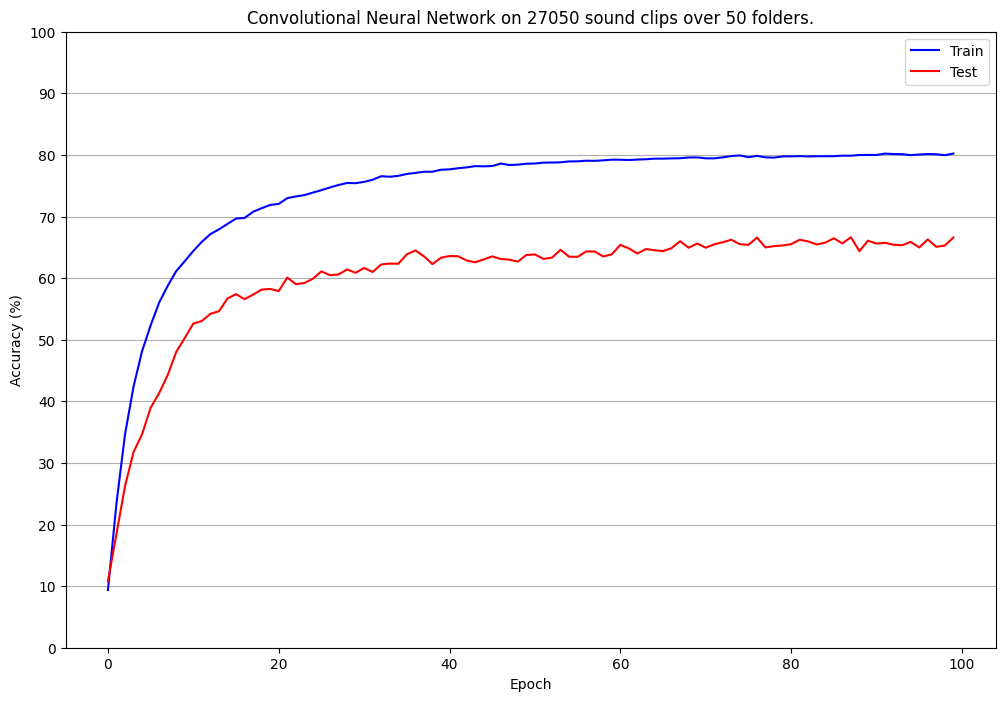

In [21]:
# to avoid extreme overfitting:
# - dropout rate between 0.2-0.5 seems good
# - learning rate around 0.001 provides best training rate without overfitting
# - train in larger batches, 64 upwards seems good
# - most seem to plateau around 200 epochs, maybe reduce to reduce total training time

reset_seed()

model = TestModel(input_shape=x_train.shape, dropout_rate=dropout_rate)
model = model.to(device)
loss_fn = nn.CrossEntropyLoss() # since we are classifying.
loss_fn = loss_fn.to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate) # adam has no momentum, but DOES have weight decay

print(sum(p.numel() for p in model.parameters() if p.requires_grad))

train_loss_hist, train_acc_hist, test_acc_hist, best_model = train_model(model, loss_fn, optimizer, epochs, batch_size, save_best_to_file=save_best_to_file, experimental=experimental)

In [22]:
# investigate TOP 5 ERROR of the model.
# compare with top 1 error (accuracy)

model.load_state_dict(best_model)
model.eval()

# get predictions for ALL testing data
k = 5
test_pred = model(x_test)
test_pred_top_k = torch.topk(test_pred, k=k, dim=1)[1]

total = 0
in_top_k = 0
for index, value in enumerate(y_test):
    if value in test_pred_top_k[index]: in_top_k += 1

    total += 1

top_k_accuracy = in_top_k * 100 / total

print(f"Top {k} Accuracy: {top_k_accuracy:.03f}%")

Top 5 Accuracy: 76.044%


In [23]:
folder_df["file"].value_counts()

file
XC416747.mp3    266
XC136060.ogg    195
XC350953.ogg    192
XC138069.ogg    180
XC352051.ogg    164
               ... 
XC466635.mp3      1
XC423913.ogg      1
XC672468.ogg      1
XC587771.ogg      1
XC734722.ogg      1
Name: count, Length: 2053, dtype: int64

In [24]:
accuracy_df = pd.DataFrame(data=[y_test.cpu().numpy(), test_pred_top_k.cpu().numpy()], index=["actual", "pred"]).transpose()
accuracy_df["in_top_5"] = [1 if accuracy_df.iloc[i, 0] in accuracy_df.iloc[i, 1] else 0 for i in range(len(accuracy_df.index))]
folder_top_5 = accuracy_df.groupby(by="actual").aggregate(func=np.sum)["in_top_5"].values
folder_counts = accuracy_df.groupby(by="actual").aggregate(func=np.size)["in_top_5"].values
accuracy_df = pd.DataFrame(data=[folder_top_5, folder_counts], index=["in_top_5", "count"]).transpose()
accuracy_df["top_5_accuracy"] = round(accuracy_df["in_top_5"] * 100 / accuracy_df["count"], 2)
accuracy_df.sort_values(by="top_5_accuracy")

,in_top_5,count,top_5_accuracy
27,0,117,0.00
29,0,115,0.00
18,0,104,0.00
19,0,112,0.00
38,0,111,0.00
47,0,114,0.00
34,0,103,0.00
22,76,108,70.37
15,78,109,71.56
2,77,105,73.33


In [25]:
# takes in a whole file as input, feeds into the model, performs sequential aggregation
# gives a single output based on aggregation strategy
def test_file(folder, file_path):
    global sample_rate, split_length, model
    samples = []
    
    # load file data and resample to sample_rate if necessary
    file_data, file_sample_rate_hz = torchaudio.load(uri=file_path, channels_first=True)
    if file_sample_rate_hz != sample_rate:
        file_data = torchaudio.functional.resample(file_data, orig_freq=file_sample_rate_hz, new_freq=sample_rate)

    # convert all audio into mono (1 channel) if audio is stereo (2 channels)
    if file_data.shape[0] == 2: file_data = file_data.mean(dim=0)
    else: file_data = file_data.flatten()

    # get total number of X second splits
    total_splits = floor(len(file_data) / int(sample_rate * split_interval_secs))
    
    # convert file data into mel-spectrogram fourier transform for feeding into CNN
    n_fft = 1024

    mel_spec_transform = torchaudio.transforms.MelSpectrogram(sample_rate = sample_rate, power=2, n_fft=n_fft)
    amp_to_db_transform = torchaudio.transforms.AmplitudeToDB(stype="amplitude", top_db=80)
    mel_spec_data_db = amp_to_db_transform(mel_spec_transform(file_data))
    
    # if file is at least X seconds.
    if total_splits >= 1:
        split_length = min(mel_spec_data_db.shape[1] // total_splits, split_length)
        mel_spec_splits = np.arange(0, mel_spec_data_db.shape[1], split_length)
        for i in range(len(mel_spec_splits) - 1):
            start = mel_spec_splits[i]
            end = mel_spec_splits[i + 1]

            mel_spec_split = mel_spec_data_db[:, start:end]

            # add testing sample to end
            samples.append(mel_spec_split.reshape(1, 128, -1).numpy())
    else:
        return None

    samples = torch.Tensor(np.array(samples)).to(device)

    preds = model(samples)

    # Ax[classes] sized array, A = number of splits in file
    # sequential aggregation via normalisation + summation (appears to be the best solution right now, but barely by much)
    #seq_aggregation_result = torch.sum(nn.functional.normalize(preds, dim=1), dim=0)
    seq_aggregation_result = torch.sum(preds, dim=0)
    prediction_order = [folder_key[i] for i in torch.topk(seq_aggregation_result, k=len(seq_aggregation_result)).indices.cpu().numpy()]
    location = prediction_order.index(folder) + 1 # because of zero index, adjust to make it 1-indexed
    
    return location, prediction_order
    
    # sequential aggregation via ranking
    # - assign each folder a rank (using topk) for each prediction, starting from 0 or 1.
    # - sum the ranks over each folder
    # - arrange each rank sum from smallest to largest
    # - smaller sums = higher predictions
    '''
    folder_ranks = {}
    
    for pred in preds:
        ranks = torch.topk(pred, k=5).indices.cpu().numpy()

        rank_value = 1 # can start at 0 as well. #1 makes sense for "first place"
        for rank in ranks:
            key = folder_key[rank]
            folder_ranks[key] = folder_ranks.get(key, 0) + rank_value

            rank_value += 1

    folder_ranks = dict(sorted(folder_ranks.items(), key=lambda x: x[1]))
    
    location = list(folder_ranks.keys()).index(folder) + 1 if folder in list(folder_ranks.keys()) else 50000

    return location, list(folder_ranks.keys())
    '''

In [26]:
is_valid_file = False

valid_files = valid_files = set([l.replace("\n", "") for l in open(f"rating_thresholds_at_least_10_classes/min_rating_{int(min_rating * 2)}.txt").readlines()])

while not is_valid_file:
    random_folder = base_path + random.choice([i for i in folder_key.values()]) + "/"
    random_file = random_folder + random.choice(os.listdir(random_folder))

    if random_file.split("/")[-2] + "/" + random_file.split("/")[-1] in valid_files:
        is_valid_file = True

print(random_file)

test_file(random_folder.split("/")[-2], random_file)

../../datasets/birdsongs-combined/train_audio/yehcar1/XC148400.ogg


(23,
 ['redcro',
  'bkskit1',
  'zebdov',
  'amtspa',
  'grycat',
  'banswa',
  'yehbla',
  'eucdov',
  'brnjay',
  'barswa',
  'scbwre1',
  'whiwre1',
  'dowwoo',
  'rerswa1',
  'cobtan1',
  'indbun',
  'comloo',
  'mitpar',
  'blhpar1',
  'amepip',
  'sheowl',
  'peflov',
  'yehcar1',
  'cubthr',
  'spotow',
  'buwwar',
  'insowl1',
  'annhum',
  'bkbmag1',
  'litegr',
  'verdin',
  'comyel',
  'brubru1',
  'blkfra',
  'combuz1',
  'yebsap',
  'leater1',
  'piebus1',
  'royter1',
  'lotduc',
  'logshr',
  'combul2',
  'brncre',
  'whbman1',
  'compau',
  'pirfly1',
  'ocbfly1',
  'oliwoo1',
  'phaino',
  'mawthr1'])

In [27]:
# do above but for EVERY SINGLE FILE in the classes used

valid_files = set([l.replace("\n", "") for l in open(f"rating_thresholds_at_least_10_classes/min_rating_{int(min_rating * 2)}.txt").readlines()])
sequential_aggregation_results = {}

for folder in folder_key.values():

    folder_path = base_path + folder + "/"

    folder_length = len(os.listdir(folder_path))
    file_counter = 0
    for file in (progress_bar := tqdm(os.listdir(folder_path))):
        file_counter += 1
        progress_bar.set_description(f"{folder} - {file_counter}/{folder_length}")
        
        file_path = folder_path + file

        if folder + "/" + file in valid_files:
            result = test_file(folder, file_path)
            if result:
                sequential_aggregation_results[folder] = sequential_aggregation_results.get(folder, []) + [result[0]]


grycat - 301/301: 100%|██████████| 301/301 [00:04<00:00, 62.86it/s] 


In [28]:
rows = []

for folder in sequential_aggregation_results.keys():
    row = {}

    results = sequential_aggregation_results[folder]

    row["folder"] = folder
    row["total_files"] = len(results)
    row["in_top_1_percentage"] = round(sum([1 if result == 1 else 0 for result in results]) * 100 / len(results), 2)
    row["in_top_5_percentage"] = round(sum([1 if result <= 5 else 0 for result in results]) * 100 / len(results), 2)

    rows.append(row)

sequential_aggregation_df = pd.DataFrame(rows)

sequential_aggregation_df["top_1_product"] = sequential_aggregation_df["total_files"] * sequential_aggregation_df["in_top_1_percentage"]
sequential_aggregation_df["top_5_product"] = sequential_aggregation_df["total_files"] * sequential_aggregation_df["in_top_5_percentage"]

print(sum(sequential_aggregation_df["top_1_product"]) / sum(sequential_aggregation_df["total_files"]))
print(sum(sequential_aggregation_df["top_5_product"]) / sum(sequential_aggregation_df["total_files"]))

sequential_aggregation_df.sort_values(by="in_top_5_percentage", ascending=False)


2.0943589743589746
14.359179487179489


,folder,total_files,in_top_1_percentage,in_top_5_percentage,top_1_product,top_5_product
7,blhpar1,31,96.77,100.00,2999.87,3100.00
42,pirfly1,35,0.00,57.14,0.00,1999.90
3,barswa,232,4.31,43.53,999.92,10098.96
6,mitpar,14,0.00,42.86,0.00,600.04
23,verdin,31,0.00,41.94,0.00,1300.14
39,brncre,32,0.00,31.25,0.00,1000.00
1,rerswa1,66,0.00,30.30,0.00,1999.80
4,indbun,40,2.50,30.00,100.00,1200.00
44,oliwoo1,42,2.38,26.19,99.96,1099.98
14,cubthr,32,9.38,21.88,300.16,700.16
